In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/street-view-house-number/train_32x32.mat
/kaggle/input/street-view-house-number/test_32x32.mat


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

## Load the data. 
PyTorch supports loadind "Street View House Number" database from the box.

In [3]:
data_train = dset.SVHN('/kaggle/input/street-view-house-number/', split='train', download=False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))
data_test = dset.SVHN('/kaggle/input/street-view-house-number/', split='test', download=False, 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

In [4]:
data_train.__dict__

{'root': '/kaggle/input/street-view-house-number/',
 'transform': Compose(
     ToTensor()
     Normalize(mean=[0.43, 0.44, 0.47], std=[0.2, 0.2, 0.2])
 ),
 'target_transform': None,
 'transforms': StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=[0.43, 0.44, 0.47], std=[0.2, 0.2, 0.2])
            ),
 'split': 'train',
 'url': 'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
 'filename': 'train_32x32.mat',
 'file_md5': 'e26dedcc434d2e4c54c9b2d4a06d8373',
 'data': array([[[[ 33,  15,  15, ...,  72,  82,  89],
          [ 28,  14,  14, ...,  40,  67,  83],
          [ 40,  18,  16, ...,  23,  35,  72],
          ...,
          [ 86,  87,  82, ..., 104, 104, 103],
          [ 84,  86,  82, ..., 110, 106, 106],
          [ 85,  89,  85, ..., 111, 109, 103]],
 
         [[ 30,  23,  17, ...,  65,  77,  79],
          [ 39,  25,  20, ...,  39,  58,  78],
          [ 41,  21,  17, ...,  29,  42,  69],
          ...,
          [ 81,  82

In [5]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)


class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


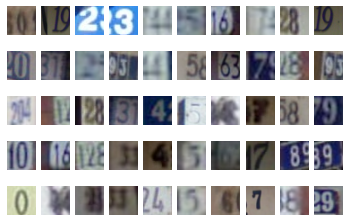

In [6]:
samples_per_class = 5
plot_index = 1
for example_index in range(samples_per_class):
    for class_index in range(10):
        plt.subplot(5, 10, plot_index)
        class_indexes, = np.where(data_train.labels == class_index)
        image = data_train.data[class_indexes[example_index]]
        image = np.moveaxis(image, 0, 2)
        plt.imshow(image)
        plt.axis('off')
        plot_index += 1

In [7]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [8]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## What is a weight decay in SGD optimizer.

![weight decay](https://discuss.pytorch.org/uploads/default/optimized/2X/3/39a9f417cb836820174d71e9a9318d5ccc6191f3_2_1035x550.png)
[source](https://discuss.pytorch.org/t/how-does-sgd-weight-decay-work/33105/3)

In [9]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()
    correct_samples = 0
    total_samples = 0
    with torch.no_grad():
        for i_step, (x, y) in enumerate(val_loader):
            prediction = model(x)
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]

        val_accuracy = float(correct_samples) / total_samples
        model.train()
        return val_accuracy

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.816953, Train accuracy: 0.420793, Val accuracy: 0.548222
Average loss: 1.458545, Train accuracy: 0.583200, Val accuracy: 0.608081
Average loss: 1.381876, Train accuracy: 0.616507, Val accuracy: 0.634974


## Let's add a new hidden layer of size 100 and ReLU nonlinearity.

In [10]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100,100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.168016, Train accuracy: 0.210371, Val accuracy: 0.244625
Average loss: 2.018099, Train accuracy: 0.270757, Val accuracy: 0.287352
Average loss: 1.854497, Train accuracy: 0.334027, Val accuracy: 0.389734
Average loss: 1.728429, Train accuracy: 0.411920, Val accuracy: 0.431575
Average loss: 1.686585, Train accuracy: 0.433317, Val accuracy: 0.434441


## Let's add batch normalization.

Applies Batch Normalization over a 2D or 3D input (a mini-batch of 1D inputs with optional additional channel dimension) as described in the paper Batch Normalization: [Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167):

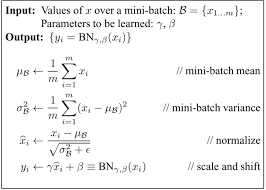

The mean and standard-deviation are calculated per-dimension over the mini-batches and γ and β are learnable parameter vectors of size C (where C is the input size). By default, the elements of γ are set to 1 and the elements of β are set to 0. The standard-deviation is calculated via the biased estimator, equivalent to torch.var(input, unbiased=False).

Also by default, during training this layer keeps running estimates of its computed mean and variance, which are then used for normalization during evaluation. The running estimates are kept with a default momentum of 0.1.

If track_running_stats is set to False, this layer then does not keep running estimates, and batch statistics are instead used during evaluation time as well.

In [11]:
nn_model = nn.Sequential(
            Flattener(),
            nn.BatchNorm1d(3*32*32),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100,100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
       )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.197860, Train accuracy: 0.233935, Val accuracy: 0.288308
Average loss: 2.052959, Train accuracy: 0.310463, Val accuracy: 0.337247
Average loss: 1.968025, Train accuracy: 0.343821, Val accuracy: 0.356836
Average loss: 1.926137, Train accuracy: 0.369194, Val accuracy: 0.390963
Average loss: 1.904338, Train accuracy: 0.386001, Val accuracy: 0.399973


## Adding learning rate schedules.

In [12]:
from torch.optim.lr_scheduler import MultiplicativeLR

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, 
                learning_rate_decay = 0.99):
    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        
        lmbda = lambda epoch: learning_rate_decay
        scheduler = MultiplicativeLR(optimizer, lr_lambda=lmbda) # addind learning rate schedule
        
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        scheduler.step() # updating learning rate
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, 
                                                                          train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

In [13]:
nn_model = nn.Sequential(
            Flattener(),
            nn.BatchNorm1d(3072),
            nn.Linear(3072, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100,100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
       )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, 
                                                       val_loader, loss, optimizer, 5)

Average loss: 2.185553, Train accuracy: 0.239668, Val accuracy: 0.302027
Average loss: 2.034667, Train accuracy: 0.325240, Val accuracy: 0.342434
Average loss: 1.964655, Train accuracy: 0.354418, Val accuracy: 0.377380
Average loss: 1.927720, Train accuracy: 0.371873, Val accuracy: 0.385093
Average loss: 1.909048, Train accuracy: 0.381548, Val accuracy: 0.387141


## Let's find where our model mistakes...

In [14]:
class SubsetSampler(Sampler):
    """Samples elements with given indices sequentially.

    Args:
        indices (ndarray): indices of the samples to take.
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)

In [15]:
indexes = np.array(range(3))
index = SubsetSampler(indexes)
for i in index:
    print(i)

0
1
2


PyTorch data object (data_train) can take only one index at a time, not an array of indices.

In [16]:
sample, label = data_train[0]
sample.view(1,-1)

tensor([[-1.5029, -1.8559, -1.8559,  ..., -0.6441, -0.6637, -0.8010]])

We have to reshape our sample by tensor.view() to be processed by Flatten() class correctly. 

In [17]:
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset.
    
    Returns:
    
    predictions (numpy array of ints): model predictions.
    grount_truth (numpy array of ints): actual labels of the dataset.
    """
    model.eval()
    predictions = np.zeros_like(indices)
    ground_truth = np.zeros_like(indices)
    count = 0
    with torch.no_grad():
        for i in SubsetSampler(indices):
            sample, label = dataset[i]
            prediction = model(sample.view(1, -1)) # important to reshape sample (3,32,32) to sample
            _, index = torch.max(prediction, 1)    # (1, 3072), otherway the Flatten() class would
            predictions[count]  = index            # take 3 as batch size and reshape a single sample
            ground_truth[count] = label            # into (2, 1024)
            count += 1
    model.train()
    
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix.

In the field of machine learning and specifically the problem of statistical classification, a confusion matrix, also known as an error matrix, is a specific table layout that allows visualization of the performance of an algorithm, typically a supervised learning one (in unsupervised learning it is usually called a matching matrix). Each row of the matrix represents the instances in a predicted class while each column represents the instances in an actual class (or vice versa). The name stems from the fact that it makes it easy to see if the system is confusing two classes (i.e. commonly mislabeling one as another)[source](https://en.wikipedia.org/wiki/Confusion_matrix).
 
 For two class classification:
 
 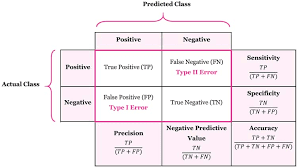
 
 For multiclass classification:
 
 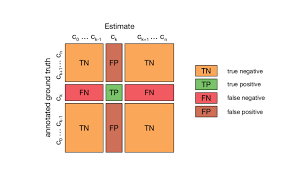
 
For ease of understanding:

![Example CM](data:image/png;base64,%20iVBORw0KGgoAAAANSUhEUgAAAlwAAAFWCAYAAAC8b0NLAAAgAElEQVR4Aey9C1iUdd7//37+7DWzuQ3b/gdNQfuj7EPAI0arhReLkKvGmujyJJJLumFu4ZGsRfPn+fwzpUysViuTysgQWlLMyMpEltVNV9QeIDaQLcBW4alldq17ruXqf91zvE8zDDDAwLy9Lpzv+fD63sP95nv4fP/j+++//x78RwIkQAIkQAIkQAIk0GME/p8eK5kFkwAJkAAJkAAJkAAJWAhQcPFBIAESIAESIAESIIEeJkDB1cOAWTwJkAAJkAAJkAAJUHDxGSABEiABEiABEiCBHiZAwdXDgFk8CZAACZAACZAACVBw8RkgARIgARIgARIggR4mQMHVw4BZPAmQAAmQAAmQAAlQcPEZIAESIAESIAESIIEeJkDB1cOAWTwJkAAJkAAJkAAJUHDxGSABEiABEiABEiCBHiZAwdXDgFk8CZAACZAACZAACfyACEiABEigvxJ4veBIf206200CJDDACMxNm+G2R5zhcouHkSRAAiRAAiRAAiTQfQKc4eo+Q5ZAAiTQxwTSUqb2cQtYPQmQgL8SKCg+7lHXOcPlESYmIgESIAESIAESIIGuE6Dg6jo75iQBEiABEiABEiABjwhQcHmEiYlIgARIgARIgARIoOsEKLi6zo45SYAESIAESIAESMAjAhRcHmFiIhIgARIgARIgARLoOgEKrq6zY04SIAESIAESIAES8IgABZdHmJiIBEiABEiABEiABLpOgIKr6+yYkwRIgARIgARIgAQ8IkDB5REmJiIBEiABEiABEiCBrhOg4Oo6O+YkARIgARIgARIgAY8IUHB5hImJSIAESIAESIAESKDrBCi4us6OOUmABEiABEiABEjAIwIUXB5hYiISIAESIAESIAES6DoBCq6us2NOEiABEiABEiABEvCIAAWXR5iYiARIgARIgARIgAS6ToCCq+vsmJMESIAESIAESIAEPCLwA49SMREJkAAJkIDvETBVYffGV9Ay6IeStn0HDJuONQsToZeE0qkgINRh3+rfo9HO7sZ3iLx/GdLjhisS9rRXQNnvN6PkKmzj9R304alYPmc8x6+n0fdy+RRcvQyc1ZEACZCAtwg0lr2CfcdKNIqrR/KcRMQaNKJ6IKjx00o0tTsFAwKGI2Z0bwuXTnasXcCpYyWolGSLjHwY6XGSgF5yNr5fiJIaSWUR/4XHKLgkQAaGk4JrYIwje0ECJOB3BNpw4mUtsSWCqEJRWSNip/WG6BFwYuls7PxKMgBDn8TZk/PQS3pPUnEnnAFAoCJ5X80I6n+kaAh00CmD6O/3BLiHq98PITtAAiTglwSazmKndFZEAaHk5VMwKcJ6yhsYoig5hIJBQYReEgAFFx8CEiABEuiHBOpPFrpvdc3vcabFfZIei/0XYO6xwlkwCfRPAlxS7J/jxlaTAAn4NYEWHN1/qgMCLSg6WYcps8I6SCePNjXVobHFBARYF7X0gUMQEhIEfYA8nVvfj/S9uyQmCGhpuY62G20QBAB6PQyDBmPw0MDOtdttpzyMvNGG+vpGtIl72kRmYluChmP4T7y3YCncaMP1luswtwmwdlcPXdBgDP+JcpHUdZsFUwua6j9H4/9ammhJGDh0OIaHDIfBw6Z6owzXLRx4MRRcA29M2SMSIIEBTkCo/xj7pHumXPS37IUTMM0K82gvVf3JN7Bm0WbZJnJpsQlz1mJFZipGBdnexkIdtsxfjcZAoOq8NCWA889i3qITCGy7juFpO7FmRhiEv76BO2dsliVM3/MB1kxW7jMTULToDqw9KUk6di0uHHxQdWpPaDqDvF3PYvcx6dZ3ST4ACbOexLyMmYgd5bkYkZfgoc9Uh/ydq7HlsIu2RCRiTdYKzJwYpuqHhzWg8WwJcrdvR0mNq6nLKMzMfhjz7k/GqJ+4KLWjdgKImfUkVmSmIybEhfLyRhkumjeQg7mkOJBHl30jARIYkAQq38lX9WvmphxkRiiCv3oWp74Q50Dc/WtBUXY8kt2ILTF32cHNSJ5wB3afbLQVJqDqfCXKTlZC/fpvQeXJUyg7X4Wq667rv/C3Nu2GKYP/pU5muvgG7pyc4VZsWdp9+CnMm3Y3VhypUxfipRDTxUIk3D3NtdgS66k5hS2LpuHO/96LxvbOV1x5MBP3ZmS7EVtimVUoyslGclwESurV3IW/liCqo3YCqDz8FNIn34F9Z9Uj640yOt/7gZGDgmtgjCN7QQIk4C8E2utQ8mKVordBSJ6WjMR7oxThwIFj1aowZ4A4mxSPtcfUL1ZnGrlr36LZKBOTeygaBLPr3Vwu5k/kFWr5blQhc7Z8tkwrmTSs5MlpKOlQfEpzeOYW/lqI2NlrNESni/w1zyJ9e0fLwfK8wqdvIH1r5/KsmLZZLuyEOjw2I1tecAe+3RlLUCk9eeGNMjqocyBHU3AN5NFl30iABAYcAdOnZShS9ipiIaIGAZETpitjUJ17FPY5KWWk6eIB+dKdJEHk2BhESvxOZwsW5J4C9IFInBiDhIkxziiJK2hiMhLGJmNBknYpkqSddjaefEVz6TNy2oNYnr0MyWODNMusrLuuGd71wDbkPbrGRfYoJIxVC2AxccvB1TjhscYVcCJPW1wmz1mG5VkPImaoVhM+Rv3XzvD60h0oc3qtrqGJWJOTh6LDh7AjK1kZK851Ib/M+fR4owyNSvwmiHu4/Gao2VESIIGBQOBM0X5VN5Lnjbfu04pMQDKegtw61xso++sKpP+ncj6pDUd3PqsqCxEPouiVFYi0bPJuQ9muR7HgRcW+pMNlaFyfiMwXDgEQUDTnDqyV7uMauwUnXkjt8l4ldaOkIQIqNYy9Prb/A2TarcTPX4CsY2twb7b8JOeF+jZgorSs7rmFT49it8ZeuvScY1gzzXpYQag/gXnTlioEYgvKKhsxRbV/TaM9QiPKjinDY3Dg9CHE2nTlvIUrUJJ9B1bI0rWg7qs2JASJe9cE1J37H0UhUThwbB9iB1mDI0fHIPFnP0VshvyZKDlbhx0We27eKEPRBD/zUnD52YCzuyRAAv2YgFCFosPKqZEgJMfZTiIGhCF5VhBKFGn2FlxA+urx8o6bqlAkFUmW2CDsfm4tIh0brgOR8HgOZr44WTGrVoomYS2G217Wqt1C/xIsZiGUEk/egK77BAQBQyH+b/0XslB9JU+7ejbL2+2pPq2aa0TQrH0OsSU2Tj9qCnbsScW9S+Xi79TlFsATwWXrYtBQe29bEDVnpUNs2aKBGw6XhkPAdbE+2b8q7N5+AI+lTUHMfw4XD1PCEJuOvZuCIJKzjKkgYHjsnbZc3ihD1gC/81Bw+d2Qs8MkQAL9lUDL+ffVy0IR83Gn/V0M4M5pc4DD8lmKloOFqM8ej1ESxSH8rQ6q3V0RC5GgNGKK4ZiXtw8JN+xX94gv4x8jSlKWxOlA23OW0vWY+UI5ZjpqAgRTG67/tQpVjU243tKIsyePouikcp+bJINXnAKq/qiuY16aQtgCGB47D3v3JDpMbaDdjMDwUZ61Qh+GHdVyC7emrxtR/+kZNH7Vgsa/fY6ykr0okydRlB2IsIQooEbeXnFz/LzDT1nSRk5MRfLERIwfOx6xo4ZrzE56owxFs/zMS8HlZwPO7pIACfRXAgLOHNyranxMeoLM7IMhOgEJeFYhzEpwonIdMmMlphE0VFJM8n9pvGiBUbGJ8FAeqNrXYwFCC84eOYjdL+xFpcayXo/VKylYjTAGd0pVrT2tIQwJkztnD82e1f4ptNSh5PXfY/eLJZ5v0LdnBhAVmwCoDls4E1SfLIT4Y/+XnL0HazOmwCCxv+aNMuzl++MnN83746izzyRAAv2PgOkCDkhtU9l6ULluGhImxiMq0vqTMO1RhdiyJtx9+KwHfe65eSkPKvc8yY0qLIiJx7x1fSe2XDVWLcJcpfQ83PRpIe6cMA1ruyi2xJoMcQuxe472Jn6tlpTkLEXs6GxUS04peqMMrbr8JYyCy19Gmv0kARLo1wQay0rUS4C2HrV8Je7Psf5Y3RpdPbYflW73+Vitomvk7N2g9uuoVO0tkzZBQEn2/ZqiUkwVFBGDmY+uxZpZknVWafYedf8YkMwIeaUqoQ6bZ7k6CQlEjk1E5uotsiVW7Xr1mLL6bbx/KAfpEz0VXiWY+WShdT+XpVBvlKHdOn8I5ZKiP4wy+0gCJNDPCbThxMvO5Z6udaYSJWcbETNRadndWVplZTWEOWpL6PUnS1AlFWs/iXRu1Hdm947r34Jl07bLwlrOYIfGTF9mziE8PDnGeS1NvR5bDrsWKi7L70SE6rAATqHu7wIib1PMc31dh5LT1U4x1g5ETZiCUR5c99NSka84dSo2MBE7Dq3FlNHDHVcX1etPoGhdx7a6ht+RjDUvJGON0Ib6mipcOHcGJ9ztATtZiPobqYi0HZAQa/dGGZ3APGCSUnANmKFkR0iABAYsgZazOOB2U7RnPc/ffwbLJ9rMNQQoRIFYxLGP0bQ1Wba5HmjEgUXZilOKQRh+vhwxkpewrAU/kvlcerSMogpfXHA5eyUWJHzVqNrDFDQnD49Nk9sDM5kka2EuW9C9iEDJljh7SaK5h+Tb5Pu1Ws4fwIon5YI5KOsQyhbK22wvQ/p5vV5pzgHI3L8TyXfIK29r+4c0m9z99RmsXfosrgf+2Bre9g8M/tU6bJ41HqPuGI+Z85dB+LoRladLsOPJZxUzqZWo+0pA5E8udL8Mrf1t8pYOaB8F14AeXnaOBEhgIBCof69QJTIwNBW7t6ciEN9pdPGHEC2gL9gqf8njfD4qv05F7E9EcwXjLctQcsMGJVj+wnTkP57o2Dzf+EGhQmwBGDofYa7Eltgajat4NBqJ6twlKJrwLmaOtooHoeUMHpvRwayUhk7EoB8qim/EK8usp+8UEV706hFzfyog2WguFl7y5HIkj30TCfZ7CIVGvPG8YhwAPPgzz44h6PU2kSRtuXLZsukUNucobKVJ0wM4dV5xBdP5fMy7fwtG2crS/2Q4YmcsQPqBZ7FWJu6jMHiwHvi3F8pQtMnfvBRc/jbi7C8JkEA/I9CCo/vVS0Ux8+dhSqx8JkXWsRgdYrYWKgxuVqHodCNiZ4jLisORnh2DIsWLuvrFTNxZlojHZibgu8oi7DsmNyUg1pGcPUV2MlJWr+ip2Yx560xIDtdb7FDNjBsO/W13QpzPkcuCFqyddTdOzHoQg1suOEw5BA0FWlydPFSv46HlxU3Ij92J6ZE/RmP1GexenY0yV/lVje16wPC4dMRAzXjB5DuQMGcZEoZ+h6KcvYoZI7G+VEwbJ5+hctUKAeqZq33bd2D808sQFfgdqioKsfzJvWpBLi1w0GCIu7bkluYLkTz6c6zJWYbx0cOBtkZcOF2iEFtiIYMxWDxLofNCGdI2+aGbgssPB51dJgES6D8EhPqPsU9DPKRPdCO2xO7pw5A+EahU7HcqOXACa2fMswimyF+vREzObIUIsl60vNvV3X1Dl2GFxfK4naEAQWNGq/Lws5ZyI7NjMTPOdXvEUsoOv2EvzGLM1CK2xOtqNPqtH6Ul3KqwZf40bHGUou3Q0GraCT0NHRSFtatjMHOrXEaK2csOKk1zOAvN3L8Mw5WzVM5omWtUjHhdk6L8mkLMm6aeNZNltHhs04H6MKzYlIgy1R6vSmzJzlBnk4REPjrPtsTsjTIkBfuhk6cU/XDQ2WUSIIH+Q6DynXx1Y4cuQ6LKQKkymbjk9aAyEKjZj1NNtuBBMdh3uCOZIi0iEflvL3BaeLdEBSIq2fWpN+cKoB7Jm/Jc3M/orMNhD10hthxXYA+KwpZNic4MnXBV5+zG2Sbvyq7IOS9i8zTPG5GQfQiPxXV8gtLeX/3oVGzu4nVEO7fno9HW3VGzdmLNWM/baUk5dBl2ZzkNuXqjjE62YEAlp+AaUMPJzpAACQwsAm2oO69e0ktY1MGSng3C8NgpGgKnBZW1zguJDaNTcaE0DzMj3JOLnLUWJef3IcZx7Y8zfcz8POzWvPwYaDTbpYNos2E88sW6XFwuHTRxGUrOX8SBLMVm8mF6SC2EjZq1D0VPLXA2QOFKeHQPzlZfxA6VEDqFkkr1lT/27IHi/Tad/heImTkXcWB1agc5o7D8hWPYO1/RN61cP5L2V4+Ze8qx41FX+YLwWM4xVH16DKrrp88/hcq/2wVmINIPXkR+zjKFYNZqQBAyn8rD2ZMLFDNx3ihDqz7/CPuP77///nv/6Cp7SQIkMNAIvF5wxNKltJSpA61rfdIf8aRadXUdGptMGBw5Cm319dDfOgpRUWEIMnggRtoFmG4IEARRZOksJgt0gwIt9/QpOyR83YKmFuf+pMChwz2rQ1qQ0IbqygtobDFB0Osx2DAKYdFhCHK3oV+a39vudgGN9dWor23EdQQhKsiEuhYdwiL/C6NGBTkOInS1WstJwspqXL8hQK83IHBoGGIinaYhPC7X1s6mxuuWstAOCMJ30A/6MYaHRyJSvNqnoyVPb5ThcYN9O2FB8XFLA+emzXDbUAout3gYSQIk4MsEKLh8eXTYNhLwDwKeCi4uKfrH88BekgAJkAAJkAAJ9CEBCq4+hM+qSYAESIAESIAE/IMABZd/jDN7SQIkQAIkQAIk0IcEKLj6ED6rJgESIAESIAES8A8CFFz+Mc7sJQmQAAmQAAmQQB8SoODqQ/ismgRIgARIgARIwD8IUHD5xzizlyRAAiRAAiRAAn1IgIKrD+GzahIgARIgARIgAf8gQMHlH+PMXpIACZAACZAACfQhAQquPoTPqkmABEiABEiABPyDAAWXf4wze0kCJEACJEACJNCHBCi4+hA+qyYBEiABEiABEvAPAhRc/jHO7CUJkAAJkAAJkEAfEqDg6kP4rJoESIAESIAESMA/CFBw+cc4s5ckQAIkQAIkQAJ9SICCqw/hs2oSIAESIAESIAH/IEDB5R/jzF6SAAmQAAmQAAn0IQEKrj6Ez6pJgARIgARIgAT8g8AP/KOb7CUJkMBAJlBQfHwgd499IwESGAAEOMM1AAaRXSABEiABEiABEvBtApzh8u3xYetIgAQ8IPDLSYkepGISO4H3PjxlcZKbnYh3P8nXuzx9vTT7eHfUTs5wdUSI8SRAAiRAAiRAAiTQTQIUXN0EyOwkQAIkQAIkQAIk0BEBCq6OCDGeBEiABEiABEiABLpJgIKrmwCZnQRIgARIgARIgAQ6IkDB1REhxpMACZAACZAACZBANwlQcHUTILOTAAmQAAmQAAmQQEcEKLg6IsR4EiABEiABEiABEugmAQqubgJkdhIgARIgARIgARLoiAAFV0eEGE8CJEACJEACJEAC3SRAwdVNgMxOAiRAAiRAAiRAAh0RoODqiBDjSYAESIAESIAESKCbBCi4ugmQ2UmABEiABEiABPyHQP0/unYNNQWX/zwj7CkJkAAJkAAJkEAfEaDg6iPwrJYESIAESIAESMB/CFBw+c9Ys6ckQAIkQAIkQAJ9RKBrC5F91FhWSwIkQAK9SqDdDNMNwVnlD/Qw3KRz+ukiARIgAQ8JUHB5CIrJSIAE/IdAa90nOPrW89hbfEmj00ZEJ01CanIK4sZFwBCgkcQfglo/wbZni4Gb9B33VqdD8K0RCA2PQHTUKBgNFK0dQTN/+RG2Pvsh9EYP+FoK0+H/vTUEwcNHYsyYOxA6zNBRFV2ONzV8hH355YDOOo5mcwjSs+citAvD2vDx68ivaLIVZYb5J79A9vx4dKEoNLy7CbNfqEH4LdautX4TgV2H1yH8pi531asZKbi8ipOFkQAJ9GsC5iYUbs5ATmmrm2604nJpgeUHiMCq3+/BjLFGN+m7F2X6sgafXTNDb3vvCoIOt8f0vdAzX6vBkdLjXepcXMZWbFw0FT0nCbrULN/KZG5B6emu8RU7YkxaiZc2pCG4B/4guHr6NRTK/hgZg+mPz+0CPxPOvbwLR2olWcMjsHQ+uiS48M964FoNaq/Zy9NBMj9tCezL7xMFl31c+EkCJODXBMxXy7H4V1m43CkKNdi2cApqdxxF9j0hncrpaeKrH2/Ckj01kuQReOlUPqL7+q92naczL5Km25wVeasxpaIeb7+6uEcEgbpG/wtpLd2O+6+YcOzgfHj7zwGdPlAFtGtPgx66Qaqi0LWyxHI6bldffp+4aV491gwhARLwNwLfXuqC2HJCKlwxHYXVJmeAF106fZCiNF03XkiKovrSW7sf9y8sQM9Q68uO+VDdtc9jZYFUrPtQ23qgKWahTVGqWTXD1ZffJ85wKYaHXhIgAf8jULHrdy5ntuIy1iF94h0I0glo/uyP2LvheUhXQOy0ch56HnF/Xolge0APfiqXSXqwqk4WHYGMzEmA8J0j3z+/acal4uOazFC5HTmlP8fGpJ6ZHXQ0YsA4xiA1YwJuhpMv8EPgRhMqPi6WLKU5O3w55wU0pOR2aX+Vs5T+4bo5PAUZGRPwQ/sUmW6kR/3ure8TBVf/eI7YShIggZ4icPUjPFGstWcrAhvf3IekMOdOo9CwCMQlpeDIhtnYptrnVYAjZx/BgljtBRzztya0tLTA/E8BZoj7jfXQGYMQfIuzfM0uauwe1vfAvhzNujsZGJ29FQvSRqpzrdqK5vMFeGThdihJl+4pRlbSYrfLXqarV9DQ3IJWk3U+TBdgQNCIYISOCIGuEyws5bQKMBoNMN8wwxg8Eoa+XppV03IdEpOCrEUpmvubFmSvw+WCLDySU67IX45zX5oRGqbxIAHo8nOpqMUhWswmNDe3wNwOmM3AzUOCEGzs4BlXlGX3mk2taG5tA2xlGYeHuD1wERybggWx9twuPjUw9Nb3iYLLxZgwmARIwD8IXH73Zc2OrnozD0laL6kAI2ZszkNt6XQUKnIe/bAaC2LjZaHN549j365nUFqrlBr2ZBGYsXQu0qdPRajtdBVgRmlONgqvAsJnyhfoJWxZkoUgQxtMxgfw/Kqpmi9ge+m9+ik4XruqaoPHpuG1p69j2u/2y+Ou7ce5Lx9B0gjlm9CMy+++hJ0b9mvPjtlKScrYiszfTkWwMrukFvPVT5C7PBOFGlOT0Wk5eGbxSOQkzkSpJM+CPSeQ4UI8S5L1rvOGdYnMVVej09Yj47UpyHNsGrc2z2wWx0Weq2vPpavuhsAAE869vh1L9mhs9A9PwTP/dyXiVGOsUd6tBgjfNqFw23LklqqXQ8NTVmLT42kI1RDKDQVZmC0TnPF47VQuwm/yje8T93BpjDeDSIAE/IVAK/74B/UvdaTkYIaW2HJgCUHqBrmwEqNaiz+T7UkSZxzuX7jajdgSc9XgyJ7VmH3vz1DaIM59Wf+Zastx+XS55jJRbWU5Kk5fwuUqk2qPij2/L34aJ6QgVaNhhX9qUoSaUPi78XikA7ElZirNW43747Nw7htFETavqboYCb/SFltikssF2Zgy61GZ2BLDP6q9rl1gH4faV8u0m2HAyNu1Y6Sh3XkupeU43ccxOzFRW2yJiWqL8cTM8cg7rRxnZwkO1+nVmJI4XVNsWYvajtmJGai46vyuOPKqHM49Xb7wfaLgUg0QA0iABPyGgKkeFYrZALHvWf99V4cIQpNycOz4CZx4/5T15/gJHHt/rsPUgbm6QGN5x32x69O2o7ndfRpZ7DeuZ5Rk6XzGE4J7MiJUrRFaWiRhZpRuS0TOaUlQh85yLLl3EyR61Zrj6keY/dCmDnIbgWvW2UfpYrB7YdNBkT0VrXGiT1ZVexMqVNwiEC6xydUrz6WsUU7P3t9NR2GdG6E0xJnWvesSnvhVNmq/dZ+q07E9/H2i4Or0iDADCZDAQCFgbryisVw1BuNCPdhzEqCD0WiE4RaD9cdohPEW+7KNGSfzt2tiSkpbjKzMNERrvlxOo8E2UxMcMxXRE+K19zYNiUdczBgsyI53CDzNynwwMChYeeoSqK2occwMmj59C+uLtRselzIfGRkp2kxQjHWvSw3VmlH6QrZqz5ijZAd/p9hytejryNPXjmbB5Yym+ZsrKNygnqkTbcUFOx7n7j+X3UWQs77YMdaqsjT++FGlcQSUY2ehxuy0I17u8IXvE/dwyceEPhIgAX8iYNdHsj4Hdmojtiyr3WNuQoV0Q5AlfAyeO56HcbZplPT5T6B07Xisl6VrRcM1E+KMBsQt2oo4AOp9KWNw6J1chHZis7i9Wb7wGRwtLsUq9qUN0ttMXZhxMneXuplDUvDSqysRbbQO2ILfztc0UFu772XUzs1FuJjsm4vIlbG1FisaBH1+RQpCDTqYTaJImYnc03AtzNSt6buQa7swJfk1teC81uqy/Qv2SGydeeG5dNf5aNGg7dxJCBbZttbglf+TjrxKRY7a7aj4MkVjz548XcbmfDw4MQLipQTN1cex/qHVqpPEl/e8job0rR58F3Q+8X3iDJd8jOkjARLwJwI6x5/+zl7HxLvdgO1M2LHLOMQI6w8Qt/QJh9hy5LzhcHXKYXKzKtOpgnwlsZ3D1Q+xTfmChhHPvLrOIbYsTdaFIHVznsZ+sHIUnrTuExKvjFHPWKXhpc1pFrEllqMzjET60yewINxXQHjQDlFcKX9cZMvYXKS58b9HnssJW/H8oqkWsWVha4zAgueKLH80KJtX+HG9Mkjmj1tVhAVJVrElRgRHTsXzb66TpbF6jqOitvuW3Hrr+8QZLo0hZBAJkICfELCc3lL09YZ12UZz8kuR1KVXNxIb//wXWbTpmyY0VH+C5r+3oPnLelSU7keFxqk5WSYXHp/cX+SirapgLeaAdanshsbLM0lDqFoKFQ8uTEXhBvmpuCvXbGVoiNLUPY9o2EkzYvrS+di7VHF6UtXw/hZgxM/jFCY6evC5XLV0kuIcpKhoRyIrOx4VspODgOOeKk2kU5F1n6LdYlFh9yE7ZhNyFIJcNK/S3X/dL8GzFlBwecaJqUiABAYiAdFQkPJf7Ydo+HauV67OMbdewXtvvYx9ecc1ZluUFTJxGmUAACAASURBVPuHv/nyJ+qO3mqwLCmamtUnA6OjI9QvclsJwbeLhxvkgqvZZqur4fNqVT2hQRozmuK9g8GjVGn7f0ArHpm0GofKt6qMf3r/uYxHhAu7HMFj1UvIly/XwJw2UntcY+5wMcOsw7jJ8UClfDn68mdNSA1TCzRfHD8KLl8cFbaJBEigdwjcrP0C9rRys7gWofgtqrvJOjcmmiOY0uEJOU9rGijpzPjsrPyFKfYsOsb68m1tUIuxy5+LJxhdvVA1BPM34gyXCS1V6gXFf36rtkdlIXtrhGXpq8LXMYfPx2v/NwU3t5stxnNF21riBM8/my/hyL7VKFTM/ohi9MDJRTJL/j3zXFqNk3qM70qLZUZTcxbZvrzsYWFXrmrMinqYt7eTKX5V9Hb1rI8ESIAE+o6ATvNFewmFZU2I7uC6meaPN+H+FYrjdOErUXYwDTrzFeS4EVvhMfGIm/wL/G/OJhzpu+73fs2mi3hDZbYAGDnCKnxvHiGajJCeNASif6o+1ehsuMYrWyeG6WEYaQQUxmZvvkl78cjcXAOfF1tipwcNtlrXdwKwuoaFIPvFeATPSUSuYpm62b7EKqbssecyEHB5iEM9RuFxEa5P17ozfaEuCnGj+8+1UNw0r3xw6ScBEvAfAroQ3BOj7m7p2tfRrA6WhJjw8csKsSXO1MwYY1kmaT37lsqQJhCPja8cRdmf/oLXXszFgrQUpK9SG0+VVDLgnBX7Vmma4Zgea31pBo1QL+01f37FJYeWL+XiTEwYfKso0HS4fWykKt/lz9VLlmIiU8NFVVqfDHA7+2NA3IwxqmZfPl1jmw0Deu65LMeVv2vMNgJo+VJtukFvcDOzXFmDFhe26Bqq1MvEgYFuylLR6NsACq6+5c/aSYAE+pSADj+fm6bRggI8su24S3tBDcXbVTMJYiHTx1oFQ2uD+iWTsWcrkkbL7/4zmZyWsDUa0f+C9NozSGJHGt7djicK1Mt8mPAAbrdf06JxarS1+GWc01w1asWRHLXoDTba2qDx/i9d+xRqleHtTTiwoqD/sdZoseH/0zDYa7sOSEzek89l7ltaotWE93PUbA0G188JUIz8Co3nxPQJXtG48/RmjVkvDTQ+EUTB5RPDwEaQAAn0FQFj3ANI0qi8tXg1pszZjnNfOt/2ZlMTSnMyMHubfKO2JXv4Yky0XQek0weqS1Ru4Lhajp171DM06ozqEMHl8o06bW+GNH/+Cc59+gnOnXf+fPxuAdbP+Rlmb1C/eMW2ZS9ynm7TjYhHlspEQw2WLHweDTKr4iaU5ixV3RkIjEHqBOt+r9BJaWp7VSjHbx7ehIq6JpjNZrQ2lGPbr9R3YvYmM2/WZQgarFmcXd705HPZWpCJbe9KZyPNqHhhKfaqjJkakXqPqz151uYX/m4pSuuc3zuYm5C3MFM9OzpkPn7u9gouTRyqwN76Pil/BagawgASIAESGNAEAkYi8+k0lP5OQxDUFmDJTDFctKcl2j9yTWLVFsm1PlDPXOXt2oVxWxbjdsN3+OxsMdZv2N/Fk4uXsHLJJjw4eSSgi0Bqyl3ap71cN7XHYlqLt2OJetLJZX3GjH1Ilb0wDRYTDblKEw21+zE7sRgzMh/BaIMJH7/2vOaVTMaMxYi2rzAZ70ZWEhSGZW33+v26E4102fp+EiHZE2Xu0ecSOLJhJv5YPBU/DwVaqkQbWRqMJjyBcY5L2jXiLUE1WP/rRBQmpWAkBNSUHleLLQBxi+7TENWuynQV3nvfJwouV2PAcBIgAb8hEDxhJZ7LuIQleeqlQCsE92IrblU+ZoQ61zZCo+9Tbf4WL/BdkubJi94+H2Gt2SyoxVtrZTFyxRNp4Y9jug8Jrk49MDGP49Ai9RKYIfY3WBWzX8MAaiuO7Nvu5pBBPHbNk5anQ9KyfXijVGNmpFMN7eeJJXblvPlcuqLSWnkcR1SnJZ2pNy5zzmg6Q7Vdl0uLVdblnSlTkJXkfqbMmdbp6svvE5cUneNAFwmQgB8TGLcoH89lT+00gdQN+XgmRX4hsy4yBasmdLooS4bcXW+hWbLPaNidk1wX5LgSx3USX4yJTtuKEy86ZwTlbTRgxnNHkaFaWpSnkvsisL0oB+H2vWD2SONdePmdfZrWzu1JxM/wCerN5tL4PnFLngGP6w9win5HntpdKK22Ls9587l0lN8Jx4I9Rzu80sez4sRrstZ5cKWPzaCupNC+/D5RcEkGgk4SIAH/JjBOFAIFuUidIBdQWlSMExbjpXfOIPs+rbQ6zNhxAhszXL3IjViwuQhn/lSk3j9WuQuXJSe+DKPn4tCOxdDUH24uM9Zqc1+GiaYwMrK34tDxM3gpe6prswBiI3UhWHDwFLYvTemwyeFJj+PQh/m4Z4SG2BCLGnYXnvnTKTyTnaZiaIyZio2vnMDLHtTTYUO8nEB3S5B6uUyyPKhVnS74DvXzBODIOet1R+LpTW89l/L6p+Kld4qQNcF2Uag8EuIJ3e1vnkKG7TSqKloakLQVbxfkuhbJExbj0IfOO0mlWdVr6yEwKPY79uX36T++//7772UNpocESIAE+gmB1wusVqx+OSnR6y02m1rR/Ld6fPZFE0z/NAOCADP0MIaORHT0HQi+RfsFr2yI+ZsmXLr8GVpvCNDrDbj51pEYEy4/rajM48pvNplgslnH14mzGXo9DDZDq67yaIW/9+EpS3BPcNOqr1th7WY0N9Sg4csmtAgGBN9iRnOrgODbInB72EgYlLNaHVVmthkNDdA5Lik3fbofUx5+XpYzemk+XpqrJaZlyTQ9/YGvN59LKQSx3M/qmmEYEoyWhivQB4/E7WEhai0kzeTCbfryCj67JiB4iB7NDS0I+mkEQofZN+m5yNSJ4K5+n+r/8QOM+vG/HTXZx3tu2gxHmJaDe7i0qDCMBEjA7wnoDEaEjhZ/pPuCOo9Fd0sIxk3wjnFGncGgnvXofJP6V44AHYLDxlh+OtVwUw32bngBtYMM1tm0GyaYjL/AxlUpitk1M04ekIstsZ6fR3lnzDrV5l5M7M3nUtpssdzosVZ2oSO6x9AwYiTGjbCWHjyi8/u1pO3Scvf294mCS2sUGEYCJEACJNCvCZhba5B3WnmNUDmeuEWP1Q/EI9igh+nv9Tj5+ibkqKzfR2B0mPdmUvo1SDbeawQouLyGkgWRAAmQAAn4CgFd6F1IBVCoaNDlvNWYnacIVHonzMWYDk0XKDPRTwLuCXDTvHs+jCUBEiABEuiXBEKQVbC1Cy1PwaEtU7u056gLlTGLHxGg4PKjwWZXSYAESMCfCOhCp6KsaB9SXZ6ek9MIT1mJt0+tQ2hnN+LLi6GPBDQJcElREwsDSYAESIAEBgIB3Yi7kP30CWS1iqdFL6G2rh7NX9uujRk0GMFBwQiNikB0V048DgRA7EOvEaDg6jXUrIgESIAESKCvCOiMIRh3j/jTVy1gvf5OgEuK/v4EsP8kQAIkQAIkQAIeE5Da4PI4EwAKrs7QYloSIAESIAESIAES6AIBCq4uQGMWEiABEiABEiABEugMAQquztBiWhIgARIgARIgARLoAgEKri5AYxYSIAESIAESIAES6AwBCq7O0GJaEiABEiABEiABEugCAQquLkBjFhIgARIgARIgARLoDAEKrs7QYloSIAESIAESIAES6AIBCq4uQGMWEiABEiABEiABEugMAQquztBiWhIgARIgARIgARLoAgEKri5AYxYSIAESIAESIAES6AwBCq7O0GJaEiABEiABEiABEugCgf/4/vvvv+9MvtcLjnQmOdOSAAmQAAmQAAmQwIAnMDdthts+cobLLR5GkgAJkAAJkAAJkED3Cfygq0X8clJiV7MyHwn0GIH3PjxlKZvPZ48h9qmC7eOdljLVp9rl640pKD5uaSK59cxIkW/PcPXVUu3j3VH7OMPVESHGkwAJkAAJkAAJkEA3CVBwdRMgs5MACZAACZAACZBARwQouDoixHgSIAESIAESIAES6CYBCq5uAmR2EiABEiABEiABEuiIAAVXR4QYTwIkQAIkQAIkQALdJEDB1U2AzE4CJEACJEACJEACHRGg4OqIEONJgARIgARIgARIoJsEKLi6CZDZSYAESIAESIAESKAjAhRcHRFiPAmQAAmQAAmQAAl0kwAFVzcBMjsJkAAJkAAJkAAJdESAgqsjQownARIgARIgARIggW4SoODqJkBmJwESIAESIAESIIGOCFBwdUSI8SRAAiRAAiRAAiTQTQIUXN0EyOwkQAIkQAIkQAIk0BEBCq6OCDGeBEiABEiABEiABLpJgIKrmwCZnQRIgARIgARIgAQ6IkDB1REhxpMACZAACZAACZBANwn8oJv5mZ0ESMBbBNrNMN0QnKX9QA/DTTqnny4SIAESIIF+S4CCq98OHRs+UAi01n2Co289j73FlzS6ZER00iSkJqcgblwEDAEaSRjUPQLtAgRR53rKth3QD9J3r86BmFsQHH8wCO1m6PUGGAzk5LWhFp/TfwMiUQF66InWa2h7qyAKrt4izXpIQEnA3ITCzRnIKW1Vxkj8rbhcWmD5ASKw6vd7MGOsURLvXafpyxp8dk18WVrLFQQdbo8Z2EKv/s2HkLy1shMgo5B//m3EDOpElgGbVEB9xQkcOPgKik5WqXsZkYwdG5Yh+Y7h6jiGeETA9MUZ5L/8LHYflj+jQWOT8dj8h5E8McoiwjwqjIn6lAAFV5/iZ+X+SsB8tRyLf5WFy50CUINtC6egdsdRZN8T0qmcnia++vEmLNlTI0kegZdO5SP6JknQAHNev27uZI90fMFZiLUhf9Hd2HLSDb6aEqyYXYIds3JwbFMyDG6SMkpNoPJgNtK3lqgjALScL8Fa8Wfogyh5by1GccZLk5MvBXLTvC+NBtviHwS+vdQFseVEU7hiOgqrTc4AL7p0+iBFaQNdXAioO68xM6OgoPRKdtopo/zGf3ZXhobYCkLM2Bgon6KWw9mYtvWU37DxRkdbKp7VEFtBiIxQ0P3qDSTPfwM98xvBGz1hGXYCFFx2EvwkgV4iULHrdy5ntuIy1uG5V4tw6M18PLNhMcJdtCnnoefR7CLO28EDW1yYYGrqLLH/QpCfzyYIX5Rg3otSoZqI3Yc/QFV1OfIPHkJZ9UWUvPCkTHi1HMxESf3Afpo6+yS5TN/eiN3z90qig7D8hWO4UF2Ooj+U48KfP8DmWVHO+PObsflYo9NPl08S4JKiTw4LGzVgCVz9CE8Ua+3ZisDGN/chKcy56BIaFoG4pBQc2TAb21T7vApw5OwjWBCrvZ/L/K0JLS0tMP9TgLhgptPpoTMGIfgWZ/majDUOReo93UyuWaCPBwrXcOoraRtjcOD0q+73Z+n1GNBMpDhcuOtPHJTEBGH3B/swRbbKrceoifNw7BAQO/spR9oDpdVIXhjj8NOhTaDx5F4USaIy9xdjXpxzZktvGI6Zm15Ey+l47LY9vyXZhVgxbZlM5EqKoNMHCFBw+cAgsAn+Q+Dyuy9rdnbVm3lICtNQOwFGzNich9rS6ShU5Dz6YTUWxMbLQpvPH8e+Xc+gtFZL1IlJIzBj6VykT5+K0FvsWc0ozclG4VVA+KzcHmj7vIQtS7IQZGiDyfgAnl81FRqtVOTpR17TdcjmXCKSEBWk5x4tt0Mo4MJJ5wbuyKznFGLLmdlwx0wsj3gKO23bAqvf/x+YFsZwL5cTkYarDWV5km97xFo8LBFbzgxBSN+6QDITthdnmpYhWSZ8nanp6nsCXFLs+zFgC/yGQCv++AfphnRbx1NyMENLbDm4hCB1g1xYiVGtxZ/J9m1cLsjC/QtXuxFbYq4aHNmzGrPv/RlKG5ybxU215bh8uhy11xyVOhy1leWoOH0Jl6tMcnHiSNF/HcLXjaiWNj9sMMWAlIem+zquS5ZhE9yeQAxEVIJk6etHGFiCXZNPNwOFRpScd5aRPC/R5TNpiLkHkc6kOFvJZUUJDp9zcobL54aEDRqwBEz1qNAQNFn/fVeHXQ5NysGxWBN0Abb5pXYzzAEGxy9ic3UBHslRzk65L3Z92nZE/2kdgj1dMvxGNhfkvvB+EmtqvC5radCg71B27ABKjpWi7qpVkOqHjcKUaalInTweNCsFoB0yoR8Y6G6ZWnEo4V9myxK3n2+Bkz1zSo/wRRWc84dA7OjByiRO/6BRSI4Aqm1/x9V91eaMo8vnCFBw+dyQsEEDlYC58QpqVZ0bg3Gh7l5YtgwBOhiN2vu1ADNO5m9XlSwGJKUtxu0/uY6TfyjAZZXYO42Gb4BgIxAcMxXRBhOaT5dDtRg5JB5xwW0Ykx7vEHialfXDwLamM7JWtxxegwWHZUFATRUqT5ZgJ6KwJi8X6bF+blMqYDjWnLyI5TesnPR2o20KbKJX+OtRbJHM1gQlRA64Z0ij290LsljhtReRiKgQd/JUj8HDLBPXlgyV56sgzKddLjs9X/v0S8Fl/vIjbH32Q+iN7h7kzg+V8K0Rqb9bjGjH3pjOl8EcA5iA5uanQOg8nWFyhcbchIpSZeQYPHc8D+NsGi19/hMoXTse62XpWtFwzYQ4owFxi7YiDkBDQRZmy2bKxuDQO7kI7W4blc3zEX/j3+RLMOK25BaXbavClozJqN/zAdZM9nPRJVo678Dwq/DFKcybsUZGc0HynTI/PWoCTZVlksB/QGiXeFVOPaLiEoGTNpMbV62HZLz7ZlNVyoAuEvBLwQVzC0pPH+8iMvfZRj7wG0R3dBLMfRGMHagEdBozWTHxCNYUYp2HYBxinwFrxe0PPOEQW46SbDMSDr+HDpO4sjYgDZ8KuF4tl1dynzag/KXZSD5/yP1JRu2sfhIqoPrY7zEzW2rWAAiasw/p/0kp0KmHYOg9GN6BsFWW56VfJ8pi6fcCAf8UXF4A56qIbs9WuCqY4f2fgFljD9QNwbIRvVu/JHUjsfHPf5HxMX3ThIbqT9D89xY0f1mPitL9qFCvZ8ryuPIM2Fdk+3VUSpa77P3PfCoPMydE4cdow/u7srD2sNTelJiqEjverkP+nDB7Fn7aCJj+egqbH81EiczUBhAkWppfnUhOnSUQ4tyn2dmsTO97BCi4fG9M2KKBSsDsPBXo6GLth2j4dq5Xrs4xt17Be2+9jH15x9X7sBwV0uEk8EMkbNqCGEFAm2BC21fXMThuHtIn2pcLAzFz05vQ35iEFcfkc1+VFRcgzAmj+Qg7zK/rkL9rObaoxCmQuecYHptMcWpH1dGnIPzDmcSTQwaKv4jE3zKKIGd5dPUpAf8UXAEaSzteGoZuzVR4qQ0sxkcJ3Ny9584sru0pvrG6m6xPnKm6GFMe2uSjHffRZgUEYcqs1A4ap8eURSuBY9nydNwrY+Mh4OzBzZi3VWI3yhYTOWstdi5/EKO699jLufuBb3DkeMssqqWrNaWouzHPzfK1gKqzkiuThv2YZjd8+BlR/Pr24ZZ6sWm60Kko+zBeZVNIPGxz8v8kYv1peWWpq3KRfs/dCL5FB7SbIS7XnP/wLazMKZAlzHrlFFIj+dtFBoUeBwHdrRGWjekVjhDRcQmFZU2ITnJvrbD54024f0WxLCfCV6LsYBp05ivIcSO2wmPiETf5F/jfnE04Ii+BPg8I6EMikQBAupVZzMY/rgSUrJuEFYfls38Y+yAObHsMsbcFekCXSZQEDIPdmIFQJhZPgkqWb2PGjuLslgYjXwnyS8ElwtcZDKpfmK1nn1eIrTF47p0XMW6Y5FdrgA4G40jck7YSZybF45GpWY578XIfXoroD/MQTc3lK8+3b7VDF4J7YoAKqZEdAKVrX0dm0koEu2ytCR+/rBBbAKJnjLE8w61n34Ls8KGlnHhsfOVJTIwMcZyCbNB9hCPbOmery2WTBkCE0FSHSpkdrkBEjYuCQXkis12AlnUjf1+6Obvr1wqxFYXNebmY6e9mM7r93ZAuCFbiQr2AmNHSMEkF7Y04K9mHGDWKIldCx+ectDTvGBIz/rh/v8MnOmbs2CoXW7JYAMZ4rM6WWgC/hAOnryhT0U8CNgI6/HxumgaNAjyy7bjMmKQ0UUPxduRqbHifPnaUJVlrg9p6fcaerUga7RRbYkKTSUs2SGvyL3f9keWYl5Eh+bkf+Z+qGZkq35cZorRQ8vOlG9PZvfLLq8cuQ8n5tym2vPAV0o+6E8mSckpOy+5CkMQAwt8uoMQREoTYcPv+Q0cgHT5EgILLPhjt11GrmHkIH9Hx1K4x7HZ7CZbPij/VWCwpywLpIQEbAWPcA0jSoNFavBpT5mzHuS9NjlizqQmlORmYvU3DhEn4Yky0XQek02v8Vaucu75ajp17LjnK7oxDUM74dCazD6c13Ca5csbWzt07i+R2uExV2Dxfbt5ATJr8yxg/XrppQ+H2Z50jO3QB3j+4AKM6ab7AWQBdMgIBYUie5byoujp3O6o1TboIKMuTjANScaf7nQmyaujpfQIUXG6Yt7RoHONXpL9a95k85MrAu29O3kH6ukUgYCQyn9aa5QJQW4AlMxMx/u4pmJb8MyRMmo71BdoiadWWuQ6L3WaNBa+8XbtwrqEVptYmnHv3eUz7VZaGlXtPenIJK5dsQn7B68gv/mRA/TExPEbDTMH5p5AwMRP5x07hxJG9mHn3/ZIZBDuvRCxI8uOZBKERJySTqgmPT8fwdgGCaOLE3Y+p49+ndsL+/hmbtlCCoBIz15WoZsDP7s/CY5L9c8lPTYdTpkmy0+kzBJR/B/tMw/qkIUMASK4/yVu6FOOOv4hxRskeLknDzA3H8bjMKjeAQTo//stXAodOlwSCJ6zEcxmXsCRP8taSpW5Fq+Q5lEUBiFuVjxmhzmcyNPo+y+Z7WbraYixJU+/7kqWxeOR7Q8yCekmttbIYueLsb/jjmJ5yl2rvo7rMfhISMgUHHo2SL42JTf/qFLZkS05+KbqTnLMWo+TYFCkGtldokt/1V/bkNEQ96WGfZ+3BhU1T+DuyA1z60anYMXEzVpy0JTyWjdjzR7F80XQMHgRUvpmNfMneLWABsmbQ9EYHWPs8mjNc9iEIGIxQ1a7lS1gydTyeeKEA56qvoPUbE0zftFoMSubnZCAhbbXK3lH05IiB80Kys+Gn1wmMW5SP57Kndrrc1A35eCYlQpZPF5mCVRNkQR57cne9hWaJebBhd05ynXeQfsC9KGMffxHLx7rusjImITsPO6b58ewWAPN1xalEJSR3/svXBtQsqbuudi9Oj+ScY7K9XOIfAjvXZWNFtlJsBWFH6UL491PZPdq9lZuCy0Fah3Ep2i/AirztWPLQTEy7NxFT7p2C2Q9lItfFUs/0u60bmR3F0kECLgiMS9uKEwW5SJ0gF1BayY0TFuOld84g+z6ttDrM2HECGzPGaGUVT3dgweYinPlTkXr/WOUuXP67U3EZRs/FoR2LEa5VUrPVKr5WVP8NC8K8gxeRn7Osg+WYGGzO+wB754s2kvz73z9a5PdPdorGj2hOw2Neg8Kw4/wxPDbRzUKhaILjgw+RfJsfT7l6DLTvE/7H999//31nmvF6gdWSzy8naex/6ExBPpnWhLzkROx1s5zjrtnGtH04ln2XuySM62EC731oXQrqb8+n2dSK5r/V47MvmmD6pxkQxEto9TCGjkR09B1WG3AesDN/04RLlz9D6w0Ber0BN986EmPC5acVPSjGksRsMsFks46vC9ABej0MNkOrnpbR0+ns453m4o+lTtXfLqCx+gIq6xuBQcMReKMOdW0/RlR0JGLuGFhW5QuKrQcxvMKtU5D9I7G3+QotdaisrEajYMBgvQnXBQPujL4To2jrzCceKPt4z02b4bY93MMlw2NAxpv5uDIpXcOukSyh2pO0DocottRcGOIRAZ3BiNDR4k/3BLvulhCMm+Cdo0qirTr7ddgedaK/JwrQY/jo8Rg+2t6R8RaDp3YfP0mgrwjog8IQOzkMsX3VANbrFQJcUlRiNERg45/P4LkN8z182UQga0cRzmxOcZwaUxZJPwmQAAmQAAmQgH8T4AyX5vjrMO6+xTiW9Agaqv+Mc2cv4nLVZ5JjuQYEh0VgXGw84mJGOix5axbFQBIgARIgARIgAb8nQMHl7hEI0CF0dLzlJ7UdMLdbNxfrdM4j+e6yM44ESIAESIAESIAERAIUXC6fAzMazn+I90qPo6KiHLWSjfRZr55BeqSA0m2rcfmnKUhP+QWCqcFckmQECZAACZAACfg7AQoujSfA1FCOnCVZKJWILFWy9iYUFpfjMspRmBOBjQV5SJIYo1SlZwAJkAAJkAAJkIDfEuCmecXQm+uOY0paB2JLkQeowfq0aSj90mnPSJWEASRAAiRAAiRAAn5LgIJLOvTtV5Dz69XSEDduveJUYivW/5+3JBvr3WRlFAmQAAmQAAmQgF8RoOCSDHdz6cuwmnWVBLp0ClBdcFG7C0XnTS5zMIIESIAESIAESMA/CVBwOcbdhAqb9WVHEADx7rqy9/MQLQ0U3QER2L7ncWUoPqpqUoUxgARIgARIgARIwL8JUHDZx//bJpRW2j3Wz9QdRy131+kG6RTLh4IlQXDsXBzaIL9/sfXvqnkveaH0kQAJkAAJkAAJ+B0BCi77kAfoEWx32z7vGdvxFSnBt8kvq26tvMJ9XAqO9JIACZAACZCAvxOg4HL5BHh4i9xNBkUJvLVdAYReEiABEiABEvB7AhRc9kcgQAe5VGrF+xUd7ccyo+IPxfYSLJ/hEyMUy4+yaHpIgARIgARIgAT8kAAFl33QAwYjPNzusX4eWTsd6ws+QavJJFsm1On0gLkJhWunYWVBjSyT3qCc8ZJF00MCJEACJEACJOCHBGhp3jHoOsTNTQHWymesSnMyUZrjSGRx5Px6PBRBtgRjkDl1pDwxfSRAAiRAAiRAAn5PgDNckkcgOGkxMiT+zjrDM5/AOE5wdRYb05MACZAACZDAgCdAwSUbYiMWvJMLxcqigoJB3AAAIABJREFULIVLz5DF2D5/jMvo3o4wf9OEcx8fR0V1q6zq5k+P44k5P8P4u+0/6cgp+ES2ZCrLQA8JkAAJkAAJkEC3CVBwKREOi8drHxYhKylCGePSb0xaibffma8yK+EyQ49GtOLItnQk3DsdS1asxhPL33WIqdri1bj/4dWoqJU2oAaFOZmYkrwdDd9Kw+kmARIgARIgARLwFgHu4dIiaRiJ9M35mP7oJZQefQtH3j2O2mvyhOHh8Rgz8Re4Z9IEjAv10ISEvIge8JlRunYKtpVKig7WW09ftn6E32w7LolQOK8VYPaaO1D29FToFFH0kgAJkAAJkAAJdI8ABZeUX7sZ5nZbQIAOhhFjkLpI/NkKmM0wB+isYiRAmkmMMjsCdLq+kyvm6rewXiq2xFbdsDattvg1RxtdOk6vxskvJyFpRN/1wWXbGEECJEACJEAC/ZgABZdk8GrzH8Vv9lyyhaTh7T+tRLBdXOlsYkuSXnSaq19HwkO7HKFZr55BemTfCJZzxzRE1TfiNUQmHNln75ejqZqOwj/VI2mE58upmoX4QOB7H57ygVawCb1FoEDjHtTeqrs/10NuPTt65NuzfPtb6dzDJRkxnSFQ4mt2znZJQpVOncLS/LnPOjKWqizBS/72JnxcIN8gb5ywGM/9PgW61os4qaxmSBre/vNf8PaONFmM0GKS+ekhARIgARIgARLoPgH/neFqN6G2sgZtNob6QXpcqZJePF2OwpOfYEYI0Ga9q1pFW7RMf+XsR7Jwk8lFYlmqHvCYTbgiKzYFL+2Yb5mhaz17EXIpBsQtesC6yT/uAcShABW2vLUVNTAtuqvfW8v/5aREGQ16BiYB+0xmWor8EvmB2Vvv9co+80Ju3mMqLYl8pTQGvts+3h311H8Fl/kKtizMhOzAnoJW4dpMFCrCOvIGG+UXBHWU3mvxAZCLpAljEGRbDr1y/o+KaoxIutNuoFUhEAfZNtkrctBLAiRAAiRAAiTQdQL+u6QYoENQ17m5zHn7yBCXcb0a4VgZbMLHefLrh4BJiB5ma027uMNL8u8GoJBgkkg6SYAESIAESIAEukLAfwVXV2h1mMeI8GF9s2EeSuFU+YnFrpa5+o/qWbqUux02w5rLCnBZ2q+oIMUl3tJIukmABEiABEiABLpCwH+XFNvNkO7Y6go8ZZ6kVXsw7hZlaC/5bwrBxHDgsmON9Dh+k6htdyt1wu0wt17CkbfeQk6ePE30iGDa4eqlIWM1JEACJEAC/kPAfwWXbiQ2vZIHk7jPqR3Q36TDlT9swvoC5/Jb1tN5iAvSwWS3zaXxXOgDzBDaAeOwCAQb+2h2y9IuA+JS45G7rVyjldKgCNwTG4Lmt5YjR7XUCPw8ykeWRKVNppsESIAESIAE+jkB/xVcAQaEjpbffai7TSqYxmBc7BiESoN8fLBD73scSdvKobR9Kmt20lyM0wENeq0dbGm4dyxv35bxoocESIAESIAEvEDAfwWXBjzdsPuQmnYXbh4EwDAKw+xGTzXS+mSQbiRWv5OL5l9lyfdlORprxDPLXB+fz351sWNvlyMLHSRAAiRAAiRAAt0mQMElQRg8IQ3ZE5wB5m+aUFvXjLZbRmFcmPS+RDMaPr0I849HIXyENNyZt69cumHxeKn8KEpf34/cfcUO+1vhExZj+aq5iLY11yxId7DFY3tBDu7pT9N5fQWY9ZIACZAACZBAFwhQcGlAM9V9hJz12Si1b0Af8jhOlMx12rn6th7rHrbZ8BoSj40bn0TSWB/a+6QLQdL8dZYfcX+a5Z9itm5Y3OPYOMQE4223Y0xkCDfKazwHDCIBEiABEiABbxGg4FKQNJ1/HVMWOu9GtEQHK4yBBsBiw8uix66VY/3CcryRloOXs3/he8JFIbTs3TWE3YWkMLuPnyRAAiRAAiRAAj1JgIJLSvfbGjyhFFti/A1pIm13bUE2Vv60CM+k2C24a6frzVBTaxPMuhAYpfvgTVdQWvwWKiqbLQZPDcPuQNJ/pyBOtmTam61kXSRAAiRAAiQw8AlQcEnGuLnsde3N5t8IFuvrjgOLLmx4VWxbjXP35PedLS5bXxo+fh1bV+yy9iV8JcoOpllm3kzVxZj90CbHvi5r8nKUFjyP6IwcPL/IB2foJONDJwmQAAmQAAn0VwK0NO8YOTPOFcmNgFqiwlOw6sl45/4tMVA3Eg9npyHckdfuqEF+hfwKaXtMb33WFmRhtl1sSSsVZ+9UYsuZ4HJeNn67/xNnAF0kQAIkQAIkQAJeI0DB5UBpwv82OzwWR3haLs4cXIcZExTLhAEG3JO2Eq/96QSyYuR5KoovwiwP6j3f1eP4TY624dPmky5m7yStq923C+dkFytKIukkARIgARIgARLoMgEKLju6b6/jj9fsHvEzAlmZ8dIAtTvAiNQnV8rDb5j77PLny+++Lm+L6PtG/M+Mj/M1Zu9UqWuQ/2HfztCpmsQAEiABEiABEhgABCi4XA7idfzTk6kqZZpB6KPLn1tx/g/Oa4ms3YpAxqK7ANNFvGc3ceHobzyeKSjC9gy5tf0WE6e4HIjoIAESIAESIAEvEaDgsoO8aTB+LtuU1YojH16yx7r8rDj2kjzuBvpmhks1QzcGz72fjwX3jYTwt0tQ6q3wzN8iLnQk7pn3BKIlPagtrbGcXpQE0UkCJEACJEACJNBNAhRcDoAG3OxwWx0VORl45IXjaGhVz/qYrl7BkW3pWFnQKssVPnGkfIO9LLYHPQGQ1xuTgjG3WOtruHBaVXHqPRHWsACdPF+fzdCpmsgAEiABEiABEhgwBGgWwjGUOoxLjQe2yTedX85bjdl51kTh4WOghxmXa5VLd45CEDfaJmScQX3sMuF8qXKmbirGOK7x0cvbZ5uhc5jAkMfS1xkCrZ9g27PFwE0Kxlpl6HQIvjUCoeERiI4aBaOBI6CFqTfChBsCzO2CtaoAPQyDPBi/3miYD9dhaqpDXeN1XLdvSQgwICwsCqNuC/ThVvezpgkCTDesz6XQboZeb4DBwGezP40iBZdktEKnP46kbeUolYRJnbW1SuEijRXdKZgxTmplVBnfg/52yJcCm1uttsNaP8Fe5XrihHgE2yzQm2rLUSFt1q26PtqDJm3EwHCbr9XgSKknhxXU/Y3L2IqNi6bKZx/VyRjiLQI3GnHi7QM4sP8NVH6lKHRoDDLnL8TM+xMxXLzYnv8cBFoulmDNsmyUKZnZUwxNxObtazEzdrg9hJ+dIiCgvuIEDhx8BUUnq9Q5I5KxY8MyJN9Bvmo4vhfCJUXpmASMRPar66QhnXKvevVxh5DpVEZvJL5pMMYOkRR07XnM/t0mrH8sWxJodcZNioAOZjScP44nHpZfYxQdI8bxn1cI6Lr+12dF3mpMmfM8mu13YXqlQSxEi4DwxQnMHDsZj23VEFtihq8qsW9rJu4dG48DZ6WXvmuV5j9h9cfWIGG2G7FlYXcKazMmI2Hrib7Z29qvh6MN+YvuQPL8bG2xJfatpgQrZk9GwroS+R/c/brfA7fxFFyKsTVEpqDsnX2YIdtAr0ik9A6Jx/aCU5gR2UezW5b2GDHuv+XLma2ni50XcEvaPCNuJBoKMjB74WqVZf3gIX3ZB0kj6QRq9+P+hQX8RdqTz4JQh7VJS1GtrGNoFCKHKgNbsDMjBWXUXEBTCZKzC5WAXPpbDi7Flg8aXcYzQk3g7K4MbDmpDA9CzNgYy12+0piWw9mYtvWUNIhuHyRAwaUxKLphd2HVwb/g7Ve2IjVJbjZBmjx8Qho27ilCWUku7gnte6EyLmURjNIGarnDH0ecZTN9kEZsPB6cGKIRziDvEYhARuZiZGTMd/ykpkzVuLXAVmPlduSUNnmvepYkI1B9eDVKJCGRc3LwfsVFVJ18G0Una3Dh9DEsnyb9rrRgwfYTkhz+6BRQsks9cw5E4bFNOVjzaLImlKKle9HIGVtNNspA4YsSzHtRuoSYiN2HP0BVdTnyDx5CWfVFlLzwpEx4tRzMREm9be+hskD6fYIA93C5GYbg0VORLf5sMMNkkj/IeoMBOts+KDdF9G6UMR4vPT0f9/9uv8t6s1amuFwyTNrwOMK5nuiSnTciorO3YkGa4uYCseBVW9F8vgCPLNyuuOsSKN1TjKykxW7FtHhqtqG5Ba22Tcu6AAOCRgQjdERIp55TSzmtAoxGA8w3zDAGj4ThJm/03BfLaMH7+ysdDQualYP81cmyPYz6oDDMy3kX+q/uxpbztqR11yzLY11fMHZU2T8dQh3yjymaPvRBlLy3FqMsUJIx81f3YMq0bMgnAz+H5dco98Ep4Km99ScOSgKDsPuDfZgi+1tYj1ET5+HYISB29lOOtAdKq5G8UHH9iSOWjr4mQMHlyQiIphNu6R9KJHjCYpx4MxI5j2WjVGY534isPXlIH22diTMLbbKep24oQvZ9GkJAloqebhMQ5MJdWl7w2DS89vR1TFMK5mv7ce7LR5A0QvkMmnH53Zewc8N+lZ01ablJGVuR+dupCFZmlyQyX/0EucszUag8YAEgOi0HzyweiZzEmbIDJQv2nEBGbIdzqpJafMwpXMNZyWbvFb+dIhNbztYGYvrSZdiS8aw1qKYaTQJs4sKZym9cN9pU+7Eytz4m46EflYydj76imKWpRFWTgMj/9Fup6uEjIuDCSecfApFZzynElrMYwx0zsTziKey0HZyvfv9/YFoYw8M2TkQ+5fJLwWU2mWAyS0zE6wyWY/iq8E4Plc4yM9DpbF7OYAj7BTaW/AXZ37TC9O13AH6IoCFG2UzHsHEPIGlCCIbFxOOX901CqNHN29jL7WNxrgkYJ6QgFfuh3B1T+KcmJI2QCmITCn+XiBy1iTVV4aV5q1GadxzPvZ+LcTbbbNJEpupiTHlokzRI5r5ckI0pH6uF1Ue11/u34GppgvO1FoXhQa6FgNAufo9s/4YGIdB1UnuqAfspNFWr9rwFagDR/1D5O8U94wELrNMdu47rkl0ECW5PIAYiKiEKqLEtP/4ILlcwOt0MZvA6Ab8UXA3FmfjNHoktrSGPo6xkLlThXcCd9eoZpEcqf9F0oSAvZDHcYoRB4wUrFm2InIqNT0/1Qi0swrsEQnBPRgQK8yTPJwChRVycsQsuM0q3eSa2nG0rx5J7N+FQ+To4TLCJkVc/wmw3Ysua3whcsxr4FWWX3dRvf9ccgj4EO57KAcStAe0GDHfZIQFn3pZI4FsG+/UMgj5yHi6cT7dyEx8QcV+WXgFPXHbMdcpZ63M0GIFcTrSicPe/wsRPYKC7/cEC6s5L9nr9ywxxKkExGu5qY1wvEvBLwaXTSzfBAgi2Pp6q8C4NhLhk5BuCy/ytCcK/PetEa1UxZi/dhVUFZzBD9kb2LD9TeY9AULDi+QRQW1ED06K7LC9606dvYX2xdn1xKfMRfksrjuYVO4SRM2Ux1r2egtfm2w+CmFH6QrZGOlsO0cyIZVlaLbacZfZflz4oCskzotx2QDA14sTL2VhxzLkbaebiRP9+oQUAeg1jsMLXLbhu+geaai+gaOsa2WEEEXJk1jxEUgm4fd4skQHDsebkRSy/YU2qV4pZSQnCX4869xYCCEqI9Os/BiRofNLpl4JLNRK2B1sV3i8DzDhX8AzW5xS4fpG66dc/v/UdweimmQM6Kjg6HoD8xgMM0tte8maczJXbTrPAGJKCl15diWjb0vCC385H4eYM5JTa56OsyGr3vYzaubnWwxHfXESuhpVfY9JKPL8iBaEGHcymKyjcMBO5p50zWwMaPgSUZP8aO77SYfi/GlFZ4xRaYr8jH92DNZNpZFL9DAjIvz8eOyV74mRpJq5F3sLxsiB63BHQQ9/BbKDwxSnMm7FGVsiC5Dtlfnp8i4BfmoVQbhh3XDet2EjelaEy9/Gx53MvTMOSLoqtrvSXeXqJgP2PgqsfYptypQZGPPPqOofYsrRIF4LUzXlIVTWvHIUnrRtEGj5+XUOUp+GlzWkWsSVm1RlGIv3pE1jQGbt0qjr7V0DbV1VoOV+pEltiLxJiI/17dsvNUAbKTtEpE+oh9PHvRmWL+q9fQPWxZ3FnUqZkDyIQNGcf0nkgwaeH1S9nuG4OvQ+paXfhZstfECbAYN0bo5OFd37c/nnjhxg7zN16e+fL7FSOq8exJE8+o9Gp/EzsGwTM2icZLaE31BepI+kJjFPvaQcQgtQNU1G4QX690JVrtjIk50bsHU/d8wiC7R7HpxHTl87H3qWuzY04kg4Ax+BRQcB5+cyW2K2gocC++ZNRvfoQ9s7h0XvlULdJNnor43ByDRJSTTj7h3lc8lLB8TzA9NdT2PxoJkoUM4miSZNjqxM9L4gp+4SAXwqu4AlpyJ6g5u0qXJ3SN0NqT7/V7Yb19QxdtzswAApovvyJuhe3GiwzK6bm66q46GjX1zEF334XALngarbZ6mr4XGVfHaFB2n8wGINHqeodmAF6TNlUjqr1AP4toOXvdThVtBtrXzyFFttLrmzrbJTEXUSy1ejUwMTQ6V7pMWVPHqKum9BYcwb5uW+oTjKi5insPjkdayaq9yh2ujp/y/B1HfJ3LceWw5IN8jYGmXuO4bHJYf5GpF/21y+XFPvlSHXYaDNqPujocm1rIaKl8xlJ8muAxJis3x9Fep9eT9RhJ/0ggRmfnVXs3xJtYcWMtBzFaG1Qi7HLn6tnY5ygNKaxvhFnuExoqVLPhlr38DlzO1y3RiDO4fEDh3hyUa9H0G1RmPn4PpzNe1LWadHAJP/JCQwfPR6xE6dg5sK1KKou1xRW+fs/VtnwkpdCn5yAgLMH1yAqbppKbEXOWouSP9dQbMmB+bSPgsunh6cTjWtvwqeyvT1GbC/6C878+S94Jk0irmLW4eH587Fqcz7KinJlL9FzVa0yW12dqJ1JvUXAdBFvaNjWGjnCOvN08wjJWNrqjP6puxkDjROzOjFMD8NI9TrkzTdpHyMzN9egwlt99JFyBFMbTF/bfux75Fy0zRCbjuUS9BYDky7SDvjgGy1o/KJR9qNeBA9C+uqVahT/EixmC9QRDFETEFCybhLmbZWYJBETjX0QB0r/jKJND2KU9oS0uiiG+AQBv1xSNNcVIOHX23tgAIzYWHAMSX1hVsEs4IqsR5EIvdUaMG7aVKDAZtepshgN36Yg/CZANyIe219diYSHrCwq9mSgdPJfkDRMVhA9vUigYt8qDavxYzA91rojOWiEemmv+XNx5O02uuSNbflSPesZfKso0HS4fWwkUCqfTbv8+XWkhql3P5saLsoL7ve+NuTPuNt5qm5OHqpWuztFp8edyTFAjeyvmn5PoSsdqH7zUczMkS5tRSH//NuIUZ6qGxqJBABl0kpomFNKw6377K5fY8Vh6ex1FDbn5WJmLE/JugXnw5Gc4fLq4LSi1WJWwauFdrGwIMdslW7ISMk9fJdQ83fnMpMuchIyRHtLtn+Fp+WyzR7OTy8RcGNTp+Hd7XiiQL3MhwkP4Hb7fYY69Z+0rcUv45zGXnrRkMORHLXBrmCjbRbL+Rg4Ole69inUKsPbm3BgRYEjzcBwBOJO6cb3c9XQROjorIDG8xKxFfZjH7G252hgLzqUs6ZVqPtKPccl/K1aLrbEFtoMc/ZiY/tlVaaze+XXIo1dhpL/v71zgYr6PPP/N4c9M43rWLuDJg6agvQ/GV2hZNW6S6BqjDuLouVfDTEkNBi2lXghMaGpq1G84dKEaqJNqjEXqoYaREu8hExSYxRKNNGESI8iZ1VahSSG2aZO13R+Zznu+TG3320uDJcB5jvnzPm998vnHZhnnvd5n/fMAQpbA3I1fYOmwOVjMbBDt47A3RLBCajG6Rb3N6chVnby7P0G/8eJGk81UeXfi5+Etv/6CKf/8BFOn/G933+rEsUP/RMWrNUWaooWz/B+uYtayUKVi4YmLH30BbR8LR24A7ayZSiX3acp5idjfrpLGxY/I1siiHvq1uFHj6xH/cVWCIIAe0sdNv1gjuqqIU/pgfyU3UbTdAjn/hxgNu0n8doxX37KuLFR6x5ixNh/9IFwh1bnP4NLUpnLeRXbnyxSlYudRMecKiiqhOuoKnXf2ynm3V6Ad/YUYKxSg6iqx4T+TiAqtxTh59i9Z7GMI42wu68y8aT1/6cBQ8Xz/JIv2E0PzEbbyk14JMuCu81Ao/ti4vpNq2BL2gFroh7Ntp3yL+Uv2juNWpW/Yfv//AfGCO3VpViqVjr5HbwxbwfmJ0pXw9DpomGr0kVD8ytYMLUacxf9GBMMDry/6wXUSz4Lng6MeUuQ5FGSGb+HQitQrHR+2lyNJx7owiA9jQ+w59jp+YgtWQbXps05LPzh06g4sBEp35JPxNl6EhsfWiQ7dZczPXpPhcVOmYNxUJxC/Px1ZKZcxdPrv49Ljedxbl+VzEeUh+hj2XTM6WHh9+m8inclN3t9f/kcjO5wIsC9966mOgC9QdsG029fzOhTAlEpcOlGuk5cXRipMBoeHgdj81k0awlbIy2w3mUBbrTjdG2dhsNIIDUrGyY/Rse9v6o6xJstQIPkLxV2lG/agnvmVMA83gg0e7armlD8wFSIJ9+VL+P4BPrJUUKJVDxlOfYuFt06yF+GKT/CypRXNByg2nFwRykOyotLYmnYslDang7Wx3fgddsiDbsxSbXBGoybidX3AY/tc0/w8yrkpFYhZ1UZZiaNBv77KhqO7cHz+yRbiWLR+7ZFt0uIISl4qnA8Fm6V2nGJYI5j45rj/j8t923DPDrm9M/HneNsPScTVk/8bDbGyw/J+m/jvm34ZP3MqNW++gfTP3KiUuCCcTI2f/ixxgo4UPWTqSiT/n8dmYHNzz+B1ES5cGa/WIcdxYU46NYaiY2ZJuZiWiQM5t0zmfTvy2GsXKQQBl3akaTUdKA6uNbizvFqg2kNUEzqZQJJ2SXYXJThR/g1YO4vD6HtkTkol3z+Ag/JgtL9ZZ2HJWTljJPx8ps7sOIHiwKeQjSnJ6O5Vm2AL2trAEZmrjqCeftmY79k7BUlRaiQxGXBiY/jneKZsqRojEx5tBxP//57snv8AnKY+DNyCwjIlyl8KTWU96WHFGq8xsurQwIVmUK04ZJwb65cphC28nHgcIlK2BKrGBPTsPLXhzBfYjdVtXoObFeUFseSDno7OHwyXliboe5FAAzpubCqcxQpFuTM0D7tpijIaC8QMKekIa+oBHtrTmKnX2HL3bEuDgV7jqN0WVbQkZity7H3aAWmjZFuTfqq6UZNxuYPjmNzUTaU5mHGlAyse/VdvBxCP74WB1BIn4gNDb/D0/cFvsQaiMVjZQfwyZ4CjBZ9dEX9axhy9nyI7UXzEcgpicht0c/34pM9C8ktxM/MX9qvhlhSoxhPgWpA6T9J0anh0uQv4KzCcWjBuh/JjM1V1WLikLMsC1WrfZqjqg9aYR0TOaElflYJjtyRhq2lq2Dr1H60uhwNxiRg1f4SnJ63SqEB882q8FfbMMlj3+NLZihMArrEbJz8MDvM2qFUM2Ba7hqczFmBtpYmtFxpRbvTANNwAW12J0x3WHBnYgIMnhOOgZqMMSA1e0XnG4LgOjgRo/OedHX8wbMdHaiRAZqnH42c9Qcw76ftuHTuv3DxT+0YMW4svmw4hev6EUgcl4KUcaOhp6ClWOBh+H7+RpzIW42rf7yI1kut+PKGaDn/NzjxDYz+9jiMn5AIA7kpuAWOjp69EedmbwxciLkDkgAFLs+ydbSiWbqVCGDo8OAGiIZY+VZj4+8+hZDt8gruabqvn8YJGVi3JwNFX7XCbgdMbsWGbkwGjhxPxvu2t3GsthZtDsB5A0hIzcLC+2ch3qitAenr8bO/LhKI0cGUmNz57lJNRxO2r30RzUMMrq3LGw44jPdg3cosxVamgGOvvaBq+u5Btv2sN8Ri3BTx7Z7qhGBaLxWS6EyI0WP02PGd7+gEwFmTQGgEKHAF4NR4oRXzEwNrqxqP+bRbnU3dEPrNKT/D8DgYhismeGscpmXld74VOYxGGQHB3oTyWrnjU6AOTwzXY9X9aTAZ9HB8cQnHdq9Hmcr7vQUTEqkOjbKPDKdLAiTQDQIUuDzwYmJhEg1YJEbItrXzkGDYjzy33yJPUddTQPNbm9WOKhNclwzLyzJGAv2PgC5+MuYDKh9bjeWrsKA8yHjTc5GsFOaDVGE2CZAACUQzAQpc3tXX4x80HMttf3Ieto9MRt799yPZHAsdHGhr/hBV2yqlspm3ldR/sXidVHoTezrwdStOn77cCw5K9YifNBmmUGx+enpObC8CBOJQWFmCquxVXew7C3s3ZvT+57yLo2JxEiABEujPBChweVdHh+mFy7HpkS3eFG/g2lmUbwvlSLwFOamBtyC9bXYjILS8h6VPaoyzG216qha8ehx5E7hV5OEx2J+6+Ayc2B+Lrc+tRFVtcMN4c9YKlC4X/c0NdjKcHwmQAAn0LAEKXBKehgm5KM3ahRXVwb94JNW8wbkbnsWkvthm0QU35vcOqosBHU8UdZHYwC+uGzMZRb94F4X2VpxtPIvmi5fQ9mf3zYJDRsAUa0L8eAuSQj3xOPCRcAYkQAIk0OMEKHApkE5beQDrdMtQXBmKRstXee7aCqy00mmojwhDA42AzhiHSdPE90AbOcdLAiRAAv2fAB2fqtbIAGtROd6t3IE8q0WVq0wwW5dg55snsXJW8LLKumHHg9wFGXa7AISO7tRmXRIgARIgARIgAS0C1HBpUQFgiJ+Mgg0VeOQpO9r+eAkX/tQOpwDodeh0+xB7WwLuNI+F0dD3vqt0o+/Bzl9ZAH3Pbi2Kl6Oavk37LT8fCSaTAAmQAAmQQNgEKHAFQaczGBE/wYj4caL2x3Vtj07X90KWbJiGOCRN5PaljAkjJEACJEACJNCPCVDg8rs4AlrOHMXbthrU19eh+ZqvYOGvTyJnnBO2TavQ+J0s5GTd4/Xm7ivVP0KCwwHn3xm+TfMbAAAZh0lEQVRU17uI6Rhi8F7d0j9Gy1GQAAmQAAmQwOAkQIFLY10dLXUoW1oIm0TIUhXraEVVdR0aUYeqMgvWVZbDGh9hzZdnkF+3wla1G697fIWZV+DEnmyf3yThMpbMmIdGANa8NViYm4V47iR66PFJAiRAAiRAAj1OgEbzCqTCxRrMzA4ibCnqAE0ozp4N2xXXlqMquy8T7B/hx1PnoNgjbIl9qxy6ihfMul628vVYMOOfUF7b6knikwRIgARIgARIoIcJUOCSAu24jLIHQvW6rVdc8GtH8X+8Abf3ImmrfRhuxfaMRZ2aK1mnN2SxzohSobX9yTkoPxPZ0atHyRQSIAESIAESGBwEKHBJ1rHN9jIOSuKBg060Kws0b8H+CAotjlPV8HcFnk+nBaADmoLh9kdL0dIPlHRKrIyTAAmQAAmQwEAnQIHLu4IO1FfXeGOewPy1FTjxTjmSPAmeZ4wFpduWe2Le53vnIrU1J6C+8hXvOKSBpNRYyBxIxOgxUbyoW/WqQcWpSI1fNRgmkAAJkAAJkMCgIUCBy7OUoqF5gyfies5/5hCKZlmgG6JTbB+69EWmKbnYuzZDVsn+hUrvJcvvvYgT9i8UracswYHjH2Pn4nt8BvNiEV0CCvZ8jBP7dyBVUeXgO2d74VJsRSeMkgAJkAAJkECUEaDA5VnwGD1MnrD7OS0EX1emO8bKatkbLmtu18kK9Ubk61Yca5Y3vG51fsBLhsU79Nb9aom80mVHp2NXeSJjJEACJEACJEAC3SFAgcsvPaPfHFnGrUrzc9nmnaxo30YsMIZwkbbeqJ5nf5lB3/JibyRAAiRAAiTQewQocHnYxujkdk6w4536YPZMAup/W+1pofNpnm5RbD/KsnsvojPgTlnrTXi/wS5L0Yq0ffieItlJDZeCCKMkQAIkQAIk0F0CFLg8BGNGwKwwJD+4eg6KKz+C3eGQbRPqdHpAaEXV6tlYUdnkaaHzqTcoNV6y7N6LxIxAfIq8+aonZ6Ki9rI80RsT0GJ7AQvK6rwpYsCYkhAZgVE2CkZIgARIgARIYHARuOXmzZs3uzKl3ZUuxwn/NmNqV6oNiLJttvX44Wq5xqprA0/GL4+WY1KEZK7TL+ZgablcAHSN34jUrBlIHhOHoRDQcuVTHKuug5b+a+6GQ1hpHbj3NL599HjXloylSYAESIAESKAHCORmzw3YCq/2keAxWZcgb7V/X1aSoppB86InIiZsiQOalLMc5vJFUNjOA7CjvroS9ZqjliZa8K+pA1fYks6EYRIgARIgARLoTwQocMlWw4iCN7ei/geFGkKLrKA6MnIJSvOT1el9mTJ8MtavzcCCtWp/YqEMw7qhJKICYyhjDLXMYNTAhjr3aCrn0WhmZ8nds0QTg3DmWun2OUhu4dALXod8gzMaTCU86x1sTrThUhIalYZdR/ej0GpR5viNG60rcODNfJVbCb8VejEjflYJ9j6T3+Ue5q6swDprQpfrsQIJkAAJkAAJkEBwAtRwaTEyJCBnQwXm/OQsbIfewMG3atB8TV7QbE5D8vR7MG1GOibFq10ryEv3bSx+2hKcPJoFW+WLKN4RWNuVmrcGhTmzED9c17eDZG8kQAIkQAIkEEUEKHB5FrtDQNuVVpmXdYMxGfMXi+8SQBAgxOhcHttjPJX68dMQB2t+Cax5xbC3teJym8QD/t8BsUYTTGPioBsIc+nHmDk0EiABEiABEgiFAAUuL6UvUZ49T355tXkFTuzJdglZOrew5S0/QAIxOhjHJHS+B8iIOUwSIAESIAESGHQEaMPlWdIOARIdkCt1iCeTTxIgARIgARIgARIInwAFLg87XRys6Z6I+9nwKdo6FGmMkgAJkAAJkAAJkEAXCVDg8gLTIXXhcm/MFahBhc2fp3ZFUUZJgARIgARIgARIwA8BClwSMIYJuTjwiyWSFODg2nkofqUGLVfscHwtQBCN5/29vxYAasRk/BghARIgARIgARIAaDQv+RTYz1SieHetL2UkgGuAbccq2Hb4kgOFCn99HDnjInS3T6CBMY8ESIAESIAESCBiBKjhkqC3n3sLjQ1nxSucYXQLW5JsBkmABEiABEiABEggLAIUuCTYdPph7pgddoWjU0kxBkmABEiABEiABEigSwQocMlwXZfFwokItOEKBxvrkAAJkAAJkMCgJkAbLunyfnMyktKHwTQkHBssBxw3TJgwKpy60kEwTAIkQAIkQAIkMNgIUOCSrGi8dQl2WiUJDJIACZAACZAACcgINNtvgdl4U5bGSHAC3FIMzoglSIAESIAESIAESKBbBKjhAiB81oRjtb/HmcZLcEIP/a066HRA7B3fRWp6GszcJuzWh4yVSYAESIAESCDaCUS5wOWA7cVlKC4XXUFovSqxvQxIyi7B5qIM0DpLixHTSIAESIAESIAEghGI4i1FO8ofmhpA2PKha6xchZkP7YbDl8QQCZAACZAACZAACYRMIGo1XC3V67C9OWROQPMW7KidhaJ0YxcqsehAJCBceQ8lzx2F3qgPcfg6/MNtcTCNTkBy8ncR34tb0I6W97Cjog6de97idrgQh5yiXMTrQhyqpFjL+7tRUd/qbkqA8K17UJSfhjCaQstb67HgxSaYh7s6sH9lwZZ9a2C+VdLhQAl2OOH8X0Bc/U4Tg1A/BgNlfhznwCXguIqGS+3QQwcnBAyLHYuxcR7/kUGm1XEdl/5wCddj4LqCbkgsUv7f6CCVmN2TBKJU4GpF1aa6LnOs2vEWFqXncmuxy+QGWAWhHbbamrAHbbSuwM612TCJ/9h6+PVZ7S5UVUu3wJMxZ3luGL04cPrlLTgo/dFhtmBZPsISuPDXS8C1JjR7HQaLXwjyl+NKEy5cE6B3CzBOpw53plhg6AVO8p5Dizn+dBIVLz+H5/c1yCrETszEY/mPIHP6+E4hTJbJiILAdez4/9/D800ALKvxyW8fJDMFoe5Ez+8pRM7Wc94mYgv34sSjKd54oIDzfAUyFzznK3L7z3Dq2EJ+n/mI9HooKgUuoeUjVGmgNVuX45F/TYAODtTvXoUq+f9doPkoWr7ORdJA/NWuMV8m9Q4Bu60UP7zswJE9+ehpfajvNgTf2MNTwOihG+JrwxMKry2xtvpXtrKtz95fj6XbxG9iz8uCnccr+sXfU8OeIuSUHPYMTPZsP3MYq8X37Q/i8NurMVY5MVnpKI+0nnAJWyKGv49yFj09/Y6LeE0ibInNjxZPd4X0cuLdcomwJdaJ04X34yqk/lhIi0B02nB1CCoWqcvKsWtDLqalpyE1PQNFL51EaZby61KAU/mzXdUSE0gAQPMLWFEpFS4GNxXBqbylQVBpuHT6WAUEXb/QfrTXP6chbMVinEUx3s9fR2b+67TlVKyiL+rE4S2lvuj/+IIMdZPAny/i+YdnQ/snQZC2O67j3S0P46kjinJcHwWQ3o9GpYZLjdWCnKxkRbIO0xYXw1hdCLs3pwnNVx2YNJznFb1IoiaQjPl56RiKv0lm/A3gRivq36+WbKX5shvLXkRL1taw7Kt8rQyM0FBzFvLy0vENj/ZHlxDSvCP++6XjKp7P3y6BHIufvvhr5ExPdNlwOa7i8LOFWL3PvY1zZgM2HJmKZ2bT9sUDzfnnqzjfcBL7X3ka+894UvnsFoH2c9j/9ie47vgS5xtP4PAx3zZi0HY72vHuARuuXnfg0vlPcPzIcbQHrcQCfUGAAlcnZQtMGtsrGBKHOwHUS1ein9ibSIfEcB8QSMlC4eIsTRV8QdEaNFYW4sdlSrvAOpy+IiA+UVvtL3ztQHt7O4S/iuavoh28HjpjLExdFOi9QovgQFtbO8T7PAUBGDoyFiZjeD8OBIcdbfbrnca1YlvG0XEwGrTnIdI3TclCwZQg66BRXR/hv6erx7Zjv2TYi16pxsJUn2ZLbxiNeetfQnttGp7/3FXwcFEVnpr9OHylJA1EUfDSviJkrglL5xJFlMKbqvPzU1hd8vMwK1/D9jUbcD682qzViwQocIlwUyyI1fzH7/0q68UlYNMDgsAN1xaZhszQOfyk7GLk7ZqJcq/RuGtWgiB+huS12s7UYMeWzbA1+3SncgYWzF2Wi5w5GYh3n/qT50tjcTDAgdO7S7F0m4ahvzkLm/9zBVLHyMcgbcEbvs0A59figZKfYqtNvR1qzlqB9cuzEa9hw9hSWYgFMoEzDbuOb4X5VgG2siJUfQY4LygF0rPYuLQQsYbrcBjvxwsrMxSkvCPrpcB1nCiXWHNaVuMRibDl6zQWOSUFEk3YdpxsfRyZcb4SURlyXo3KaffJpPUh/L0GGIhH0RygCLMiQIAClwj9RgTIs8sBRyDwPzEDEkR1qELgUk5SWxOmLNWEg9tWdb7XVZ6ENaDPhxosmKohaHmabK7GE/OqUfCLQ8hLDyIh1K7CzKmeiupnc3UpFlS/hc1vvoTUUcG+EHw2XY7mOjQqD6C4m29uqEPnQUnzrE6br2CtqkfVjRTnVRyWbIFlLpzq98SWIWUaxmG7V2twquEqMuOie1tRd/s0fH/2dzDCvTug1/8NFXuo8erGJ9JXVf9Nlwb1dp8etf3zEDcG9Xok3g40IFaihW1Hu1tD6+uEob4mQIFLJK61nSimx6i/YsVtH76ikIC/z4gHRUcr6ms9Ec/TIrsWSjhfqbHt6Cmr/SzOLkXSB2u67WJi+5NzMPQ3JzHfz/YmRgYXFl0jPIsnflDk1l5pjzms1K/6Xpvs/NM5SOXAKRNG+B/6kLHItADn3Yq/i5/7BEr/lQZ3zuh7C7D9Xvkcc8wOZK45Lk9krMsE9Hdk4sT5TFk95x9ex133bZClaUZiErHhWBNkJZ3nUJDyQ5zQrMDEviJAgUsk3XYJZ883YViH6OjQ/YoB9DeaVMaGzY2fokUwwNHhKSh9CjB+Oxmm8MxmpA0x3N8ItDn9amCEry7j4C9+AptqzBbJZ0HAsQrJCS5JWWv2Etz5rS9x7LeVaFRpyGrR8hVgUh6YldQPNVhWXA3rnmxtLY6q30Ct1uHZqibszLUEKuTNM6VkIMngQFttneQAijt7ZBpSTdeRnJOmPS5vK70QkB05norxcYF+TOkxYhQAt8DVcOYcnPn0y6VaFe8/UFUOE7pLINDHs7tts36fEKDAJWK+VomlD1eGBPzgpkU4GKBkwavHkTeBElcARAMz69oWzMzcpfardc2uFiLcMyzYtsSnmRJaUa+SyJLxy5pyTHILUzn5T8C2+p9RLCtnR8s1B1KDGL8n5ZVgXe4MmAw6CPYmvPofOSiXqm/EMTWXov5KFqxB7LnyNlTgwekWiDbybedrUPzwKjQqVq1x22605JQgXtP2UVpYh9TFJUgFoLbzSsbeN7eG0Ia0vZ4LtzZIf+//BU7NH1Ge/vQYnzoVOObW3nzmOujA70APHz5JgASCEYhOP1zBqHQjXxf0C6gbjbNqZAmIwpXy7WdEeRv2I2+KWi1lHGmE6w2kLnvCK2x5mwnHnjC9BC8szugUtsR2dEYLCn65v1PI8bbrDlS9f0mZJIunrtyPAqtL2BIzTOMy8MJv1sjKuCI1qG/u/u2iDrVLPI2++iDp9mkYHWzbWDGMPrU3U/TNKAmQwMAjQA3XwFszjrjfEzDi7tQE+Sh1CVj34ceyNMdXrWg5/xHavmhH25VLqLe9gnrpVTuy0v4jK5fNUJ/u0yWgsCgN9bKTg4D3Xh3N5jJQOEsxblGAS5yFopT1KFNozHrCnrHfaIjiDH2/pam5BkwkARIYrAQocPX0ygbclujpzthe/yRgx49nrMLeuhKV80/Bfhlvv/EydpTX+N2K7Nqc0mAxaetaTBPTAMhdMTQ2NkHIFq+v0nilfBfaTekw6d40oEHR1oVWzE9UC2gaLffLJKfzL75x/Y/Q6QstoACoyBSVc4okX3sMkQAJkICCQHQKXDEGpKakwXBbT9paOeC4YYJ5FP8FKz5jgyNqzseu/8zC0A7XF7PoW0s8sPrXtrM4uEPj3k3U4LVji7HO6nPF4DhfjZkPr+9hHi7npCE3erndr/F/V92jXP6s+1uKIY+7FwqOGPfPEA/Pd76abLh4YyFS/G4rOnHulOT03ahvagutvTBONkkCJDA4CESlwKWLz8DmlzIGxwpyFn1DYMgIxI+JU3/JjopD0UtpMD00FVsV24Ft1yQCiXAZZQGELXNKGlLvvQf/XbY+4KEM9WSHAX7tBtV6LHOqxf/WmV9hQ+W7tXMYqRN8wqR6XP0/xTAigBsIjeE7JX6MUiaOpXZLgxGTSIAE/BOg0bx/NswhAR+BgMbsBqTOVd7FCTTWNnVuU4mN2E+9oeE2Ig3rXj2EEx98jF0vbUVBdhZyVorbgF151eHyF9qW5+1X1N7i9YYAWt2GJrT72RJvOae+KGTYsABtdWUKESsr1UY34JNLAXwadFzFKYmT1PFjh0Vs1OyYBEhgYBKgwDUw142j7mcEDN+erB6R+zogMcPeohZ+8raVwDohDtKTrQ5H1x1qbn3jU3XfcOCdMrWrE4NBKmQoq1Wjol7juiHHR3i1Wp0+VK1AUzbYr+P6sXdB6lrycK1aqPRMwPnHT+DzoR6LKebo9jLv4cInCZBA6AQocIXOiiVJwC8BQ6z29pRHvNHpNTQiyg39z+rw7Lazfvvwl2GvXIRNb12WZAuof3EZtqucmRoxf1pgI/eqJ5fBdlG6FdqK8kcXua7fkfSAkfm425/Xemm5IGGn3+3QIBV7IjsmEZn3+a5OOb+1FOc1NZlOnCh/TtLjfNw1sHdTJXNhkARIoK8IKP/l91W/7IcEBj8BiU2UALXmqnzLFkzauAR3Gv6GC6eqUbz2lbBPLh5cOw+/r87A3fFA+znRR5YG3vQnMCnoZdhNKH5gKqqsWUiAE022GrWwBSB18Sy1E1iNLgMnncWKpevx4L0JgM6C+VmT1TZygRvodu6U7EeBfZ5LUBowb81hnCrLlNm5nXqlEI/t891jl/nzOZI76ro9BDZAAiQQJQQocEXJQnOaESBww3cdUHzSLAAK7VVzNZZmV4cwMI+eLHBRe0MNDip8ZUlrrHtcw1+XtIAk3GirVnmX92VnodAaWFPmK+sLCU610GlvqMZWcczm5ZgTAYFLP2E+npm+AU8dc4/zSBGmnDmEny6e03kpc8NvilAhsd0CClA4N9E3KYZIgARIIEQC3FIMERSLRREBbRv0wABiNAyamrfAdt61Pacbl4WV6YGb8Je7dcsbaAtnTJIGC7YdCnqlj6R4gKB4HdGakK7jUZqgj7prhv92h+gjdOpPj8yyIzJbLnx+HM+uKcJTRUphKxbP2B4Frbf8L6PMtxngPTTivwZzQiag/IMKuaL/gt38t+K/YeZoEqDApYmFidFMQDc8Vr1dJtke1GKjM30XVo2Mg6db3ak6zH3mXazLU59mdBUwomDDfpz8YL+6nYYtaPRzEhHIwM4396MwXX2NkKvdNJT+5jjypoRgdGQtwYHKrZpXAnW2lb4Ee4/67n50T8z1UMmbcTAo7LMME3Kx95klMMsquiPuy8G1sno9bUginjlzBI9N99lzqfqc+CBe+91RZN4RmrZRVT9KEkaMFX2buV+j9H2+RezpejA+9bePxjjFxIYN68bnkeujoNn70Vtu3rx5syvd7K50Xd38bzOmdqUay5JAnxB4+6jLOWV//nwKX7XibOMF2G84odcbMPS2BCSb5acVw4EltnvhYhsMI01ob7kMvSkBdyZq+A4LoXHHlcu4cM0J00g92lraEfsdC+JH9ZwbCMHhgENw/b7WidpBvR6GW1VSW9CRetY7O6tn/Oo52y+ioeE8rjoNGKF34EunAXcl3YWxd2gcegg6uv5boLK6pnNwPcWt/840MiMb7Hyb7bfAbOyS6BCZheijXj3rnZs9N2CPtOEKiIeZJNDzBHTD4zApPQSNUxe7FttNmuhqV3TS2p2XYUwCJo1xtWAa03V7rWB96wwGtRYxWKU+yNfHJmLKvYmY0gd9sQsSIIHoIsAtxehab86WBEiABEiABEggAgQocEUAOrskARIgARIgARKILgIUuKJrvTlbEiABEiABEiCBCBCgwBUB6OySBEiABEiABEggughQ4Iqu9eZsSYAESIAESIAEIkCAAlcEoLNLEiABEiABEiCB6CJAgSu61puzJQESIAESIIFuEaAPrvDwUeAKjxtrkQAJkAAJkAAJkEDIBChwhYyKBUmABEiABEiABEggPAIUuMLjxlokQAIkQAIkQAIkEDIBClwho2JBEiABEiABEiABEgiPAAWu8LixFgmQAAmQAAmQAAmETIACV8ioWJAESIAESIAESIAEwiNAgSs8bqxFAiRAAiRAAiRAAiEToMAVMioWJAESIAESIAESIIHwCFDgCo8ba5EACZAACZAACZBAyAQocIWMigVJgARIgARIgARIIDwCFLjC48ZaJEACJEACJEACJBAyAQpcIaNiQRIgARIgARIgARIIjwAFrvC4sRYJkAAJkAAJkAAJhEzglps3b94MuTSA3ZUHu1KcZUmABEiABEiABEhg0BPIzZ4bcI7UcAXEw0wSIAESIAESIAES6D6BLmu4ut8lWyABEiABEiABEiCB6CJADVd0rTdnSwIkQAIkQAIkEAECFLgiAJ1dkgAJkAAJkAAJRBcBClzRtd6cLQmQAAmQAAmQQAQIUOCKAHR2SQIkQAIkQAIkEF0EKHBF13pztiRAAiRAAiRAAhEg8H8H+sdqOfF/AQAAAABJRU5ErkJggg==)

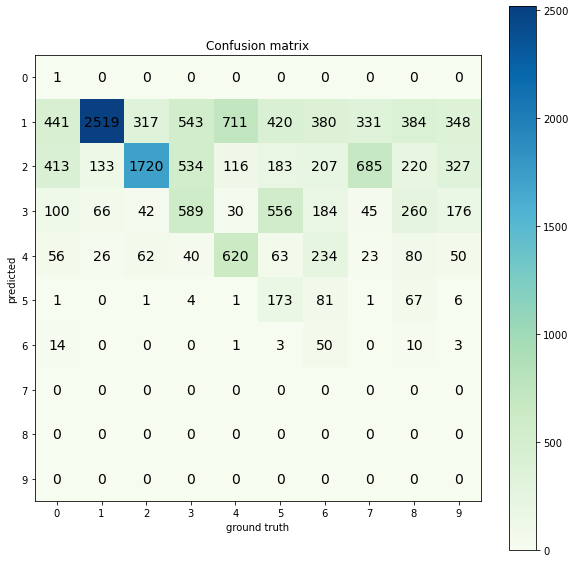

In [18]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix.
    
    confusion_matrix (numpy array of ints, x axis - predicted class, y axis - actual class):
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth.
    
    Args:
    predictions (numpy array of ints): model predictions for all validation samples.
    ground_truth (numpy array of ints): ground truth for all validation samples.
    
    Returns:
    (numpy array of ints, (10,10)): counts of samples for predicted/ground_truth classes.
    """
    confusion_matrix = np.zeros((10,10), np.int)
    index = tuple(np.array(list(zip(predictions,ground_truth))).T)
    np.add.at(confusion_matrix, index, 1)
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

## Let's visualize the most often mistakes the model makes.

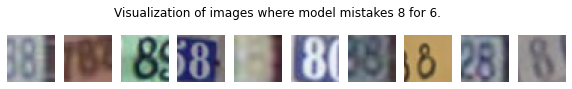

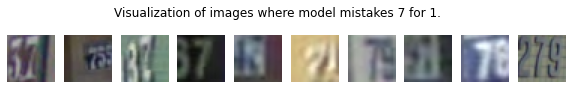

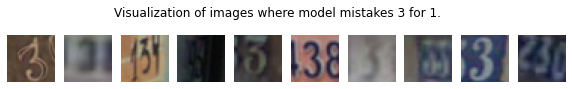

In [19]:
data_train_images = dset.SVHN('/kaggle/input/street-view-house-number/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset.
     
    Args:
    indices (numpy array of int): array of indices to visualize.
    data (PyTorch Dataset object): dataset with the images.
    title (string): title of the plot.
    max_num (int): max number of images to display.
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = np.moveaxis(data[index], 0, 2)
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class.
    
    Args:
    predicted (int 0-9): index of the predicted class.
    gt_class (int 0-9): index of the ground truth class.
    predictions (numpy array of ints): model predictions for all validation samples.
    ground_truth (numpy array of ints): ground truth for all validation samples.
    val_indices (numpy array of ints): indices of validation samples.
    """
    validation_set = data.data[val_indices]
#     validation_labels = data.labels[val_indices
#     assert np.array_equal(validation_labels, groud_truth)
    
    indices = np.where(np.logical_and(predictions == predicted_class, # finding intersection of two
                                      groud_truth == gt_class) == True)[0] # boolean arrays
    
    visualize_images(indices, validation_set, 
                     f'Visualization of images where model mistakes {gt_class} for {predicted_class}.')

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 3, predictions, gt, np.array(val_indices), data_train_images)

## Let's trying to achieve the 80 % accuracy or higher.

In [20]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
USE_GPU = True
DEVICE = torch.device("cpu")

In [59]:
from torch.optim.lr_scheduler import MultiplicativeLR

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, 
                learning_rate_decay = 1, device=DEVICE, verbose = False):
    
    model = model.to(device)
    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        
        lmbda = lambda epoch: learning_rate_decay
        scheduler = MultiplicativeLR(optimizer, lr_lambda=lmbda) # addind learning rate schedule
        
        for i_step, (x, y) in enumerate(train_loader):
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader, device)
        
        scheduler.step() # updating learning rate
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        if verbose:
            print("Epoch: %d, Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (epoch + 1,
                                                                                         ave_loss,
                                                                                         train_accuracy,
                                                                                         val_accuracy))
        if epoch == (num_epochs - 1) and verbose == False:
            print("Epoch: %d, Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (epoch + 1,
                                                                                         ave_loss,
                                                                                         train_accuracy,
                                                                                         val_accuracy))
    return loss_history, train_history, val_history

def compute_accuracy(model, loader, device):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()
    correct_samples = 0
    total_samples = 0
    with torch.no_grad():
        for i_step, (x, y) in enumerate(val_loader):
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            prediction = model(x)
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]

        val_accuracy = float(correct_samples) / total_samples
        model.train()
        return val_accuracy

In [22]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler, pin_memory=True)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler, pin_memory=True)

In [23]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

loss = nn.CrossEntropyLoss().type(torch.FloatTensor)

Firstly we change number of epochs. Let's set it 20.

In [24]:
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]
weight_decays = [1e-1, 1e-2, 1e-3, 1e-4]
learning_rate_decays = [0.9, 0.99, 0.999, 0.9999]
batch_sizes = [32, 64, 128, 256]

In [25]:
if USE_GPU and torch.cuda.is_available():
    try:
        DEVICE = torch.device("cuda:0")
        print('using device: cuda')
    except:
        print('using device: cpu')
        DEVICE = torch.device('cpu')

using device: cuda


In [26]:
loss_histories = list()
train_histories = list()
val_histories = list()

for lr in learning_rates:
    
    optimizer = optim.SGD(nn_model.parameters(), lr, weight_decay=1e-1)
    loss_history, train_history, val_history = train_model(nn_model, train_loader, 
                                                       val_loader, loss, optimizer, 5,
                                                          learning_rate_decay=0.999)
    loss_histories.append(loss_history)
    train_histories.append(train_history)
    val_histories.append(val_history)
    
    for layer in nn_model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

Epoch: 5, Average loss: 1.968346, Train accuracy: 0.368648, Val accuracy: 0.359225
Epoch: 5, Average loss: 1.329205, Train accuracy: 0.643808, Val accuracy: 0.642277
Epoch: 5, Average loss: 1.783319, Train accuracy: 0.447855, Val accuracy: 0.459286
Epoch: 5, Average loss: 2.209888, Train accuracy: 0.215132, Val accuracy: 0.219371


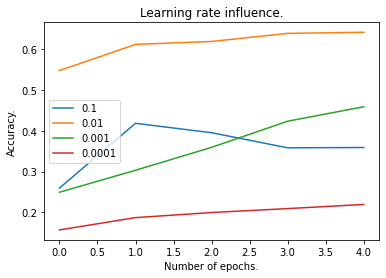

In [27]:
count = 0
for val in val_histories:
    plt.plot(val, label = learning_rates[count])
    plt.title('Learning rate influence.')
    plt.xlabel("Number of epochs.")
    plt.ylabel("Accuracy.")
    plt.legend()
    count += 1

In [28]:
loss_histories = list()
train_histories = list()
val_histories = list()

for wd in weight_decays:
    
    optimizer = optim.SGD(nn_model.parameters(), lr = 1e-2, weight_decay=wd)
    loss_history, train_history, val_history = train_model(nn_model, train_loader, 
                                                       val_loader, loss, optimizer, 5,
                                                          learning_rate_decay=0.999)
    loss_histories.append(loss_history)
    train_histories.append(train_history)
    val_histories.append(val_history)
    
    for layer in nn_model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

Epoch: 5, Average loss: 1.331308, Train accuracy: 0.642392, Val accuracy: 0.637909
Epoch: 5, Average loss: 0.858312, Train accuracy: 0.753353, Val accuracy: 0.733329
Epoch: 5, Average loss: 0.804151, Train accuracy: 0.763284, Val accuracy: 0.746707
Epoch: 5, Average loss: 0.802192, Train accuracy: 0.764307, Val accuracy: 0.749437


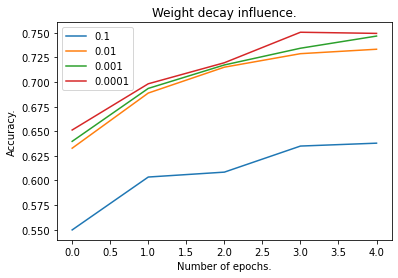

In [29]:
count = 0
for val in val_histories:
    plt.plot(val, label = weight_decays[count])
    plt.title('Weight decay influence.')
    plt.xlabel("Number of epochs.")
    plt.ylabel("Accuracy.")
    plt.legend()
    count += 1

In [30]:
loss_histories = list()
train_histories = list()
val_histories = list()

for lrd in learning_rate_decays:
    
    optimizer = optim.SGD(nn_model.parameters(), lr = 1e-2, weight_decay=1e-4)
    loss_history, train_history, val_history = train_model(nn_model, train_loader, 
                                                       val_loader, loss, optimizer, 5,
                                                          learning_rate_decay=lrd)
    loss_histories.append(loss_history)
    train_histories.append(train_history)
    val_histories.append(val_history)
    
    for layer in nn_model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

Epoch: 5, Average loss: 0.787630, Train accuracy: 0.768539, Val accuracy: 0.770255
Epoch: 5, Average loss: 0.797391, Train accuracy: 0.765058, Val accuracy: 0.749915
Epoch: 5, Average loss: 0.787257, Train accuracy: 0.768283, Val accuracy: 0.759812
Epoch: 5, Average loss: 0.791260, Train accuracy: 0.767481, Val accuracy: 0.755921


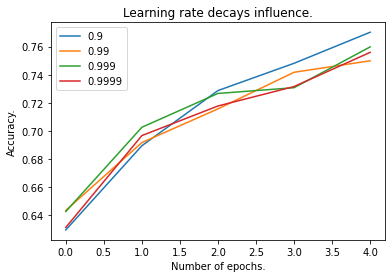

In [31]:
count = 0
for val in val_histories:
    plt.plot(val, label = learning_rate_decays[count])
    plt.title('Learning rate decays influence.')
    plt.xlabel("Number of epochs.")
    plt.ylabel("Accuracy.")
    plt.legend()
    count += 1

In [32]:
loss_histories = list()
train_histories = list()
val_histories = list()

for batch_size in batch_sizes:
    train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                               sampler=train_sampler, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                             sampler=val_sampler, pin_memory=True)
    
    optimizer = optim.SGD(nn_model.parameters(), lr = 1e-2, weight_decay=1e-4)
    loss_history, train_history, val_history = train_model(nn_model, train_loader, 
                                                       val_loader, loss, optimizer, 5,
                                                          learning_rate_decay=1e-3)
    loss_histories.append(loss_history)
    train_histories.append(train_history)
    val_histories.append(val_history)
    
    for layer in nn_model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

Epoch: 5, Average loss: 0.698547, Train accuracy: 0.793144, Val accuracy: 0.784588
Epoch: 5, Average loss: 0.791024, Train accuracy: 0.767276, Val accuracy: 0.748891
Epoch: 5, Average loss: 0.939877, Train accuracy: 0.728628, Val accuracy: 0.722272
Epoch: 5, Average loss: 1.152351, Train accuracy: 0.680016, Val accuracy: 0.676950


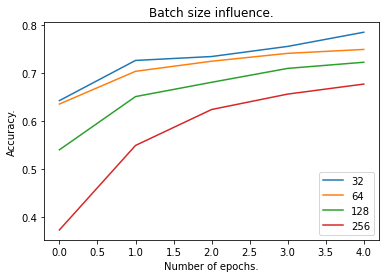

In [33]:
count = 0
for val in val_histories:
    plt.plot(val, label = batch_sizes[count])
    plt.title('Batch size influence.')
    plt.xlabel("Number of epochs.")
    plt.ylabel("Accuracy.")
    plt.legend()
    count += 1

## Hidden Layer size influence.

In [34]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 10), 
         )
nn_model.type(torch.FloatTensor)
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)

In [35]:
batch_size = 32

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler, pin_memory=True)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler, pin_memory=True)

In [36]:
if USE_GPU and torch.cuda.is_available():
    try:
        nn_model = nn_model.cuda()
        USE_CPU = False
        print('using device: cuda')
    except:
        print('using device: cpu')
        USE_CPU = True

using device: cuda


In [37]:
optimizer = optim.SGD(nn_model.parameters(), lr = 1e-2, weight_decay=1e-4)
loss_history, train_history, val_history = train_model(nn_model, train_loader, 
                                                       val_loader, loss, optimizer, 25,
                                                       learning_rate_decay=1e-3, verbose=True)

Epoch: 1, Average loss: 1.403940, Train accuracy: 0.562434, Val accuracy: 0.680022
Epoch: 2, Average loss: 0.944559, Train accuracy: 0.717452, Val accuracy: 0.708348
Epoch: 3, Average loss: 0.806727, Train accuracy: 0.757448, Val accuracy: 0.750324
Epoch: 4, Average loss: 0.718499, Train accuracy: 0.786097, Val accuracy: 0.770869
Epoch: 5, Average loss: 0.658882, Train accuracy: 0.804269, Val accuracy: 0.763156
Epoch: 6, Average loss: 0.618132, Train accuracy: 0.817340, Val accuracy: 0.773326
Epoch: 7, Average loss: 0.585985, Train accuracy: 0.827919, Val accuracy: 0.812504
Epoch: 8, Average loss: 0.557486, Train accuracy: 0.834505, Val accuracy: 0.816600
Epoch: 9, Average loss: 0.534344, Train accuracy: 0.843037, Val accuracy: 0.760699
Epoch: 10, Average loss: 0.515809, Train accuracy: 0.846159, Val accuracy: 0.813323
Epoch: 11, Average loss: 0.495989, Train accuracy: 0.854725, Val accuracy: 0.810798
Epoch: 12, Average loss: 0.484421, Train accuracy: 0.855373, Val accuracy: 0.825677
E

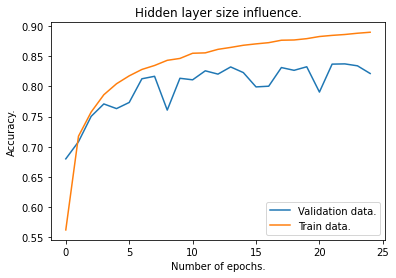

In [38]:
plt.plot(val_history, label="Validation data.")
plt.plot(train_history, label="Train data.")
plt.title("Hidden layer size influence.")
plt.xlabel("Number of epochs.")
plt.ylabel("Accuracy.")
plt.legend()

## Adding a second layer.

In [39]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)

In [40]:
if USE_GPU and torch.cuda.is_available():
    try:
        DEVICE = torch.device("cuda:0")
        print('using device: cuda')
    except:
        print('using device: cpu')
        DEVICE = torch.device('cpu')

using device: cuda


In [41]:
optimizer = optim.SGD(nn_model.parameters(), lr = 1e-2, weight_decay=1e-4)
loss_history, train_history, val_history = train_model(nn_model, train_loader, 
                                                       val_loader, loss, optimizer, 25,
                                                       learning_rate_decay=1e-3, verbose=True)

Epoch: 1, Average loss: 1.670520, Train accuracy: 0.441866, Val accuracy: 0.621323
Epoch: 2, Average loss: 1.036158, Train accuracy: 0.683753, Val accuracy: 0.693468
Epoch: 3, Average loss: 0.874676, Train accuracy: 0.734635, Val accuracy: 0.727391
Epoch: 4, Average loss: 0.771550, Train accuracy: 0.766236, Val accuracy: 0.752099
Epoch: 5, Average loss: 0.701614, Train accuracy: 0.790107, Val accuracy: 0.790185
Epoch: 6, Average loss: 0.653989, Train accuracy: 0.802563, Val accuracy: 0.799195
Epoch: 7, Average loss: 0.616665, Train accuracy: 0.813944, Val accuracy: 0.796464
Epoch: 8, Average loss: 0.587080, Train accuracy: 0.822134, Val accuracy: 0.805611
Epoch: 9, Average loss: 0.558403, Train accuracy: 0.832099, Val accuracy: 0.774282
Epoch: 10, Average loss: 0.535737, Train accuracy: 0.837525, Val accuracy: 0.743226
Epoch: 11, Average loss: 0.518878, Train accuracy: 0.843890, Val accuracy: 0.819603
Epoch: 12, Average loss: 0.500903, Train accuracy: 0.849708, Val accuracy: 0.791277
E

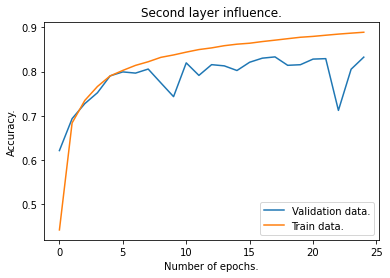

In [42]:
plt.plot(val_history, label="Validation data.")
plt.plot(train_history, label="Train data.")
plt.xlabel("Number of epochs.")
plt.ylabel("Accuracy.")
plt.title('Second layer influence.')
plt.legend()

## Adding a batch normalization.

In [43]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)

In [44]:
if USE_GPU and torch.cuda.is_available():
    try:
        DEVICE = torch.device("cuda:0")
        print('using device: cuda')
    except:
        print('using device: cpu')
        DEVICE = torch.device('cpu')

using device: cuda


In [45]:
optimizer = optim.SGD(nn_model.parameters(), lr = 1e-2, weight_decay=1e-4)
loss_history, train_history, val_history = train_model(nn_model, train_loader, 
                                                       val_loader, loss, optimizer, 25,
                                                       learning_rate_decay=1e-3, verbose=True)

Epoch: 1, Average loss: 1.425244, Train accuracy: 0.539348, Val accuracy: 0.638659
Epoch: 2, Average loss: 1.018937, Train accuracy: 0.680135, Val accuracy: 0.729848
Epoch: 3, Average loss: 0.891283, Train accuracy: 0.723424, Val accuracy: 0.686506
Epoch: 4, Average loss: 0.819475, Train accuracy: 0.743542, Val accuracy: 0.772917
Epoch: 5, Average loss: 0.766929, Train accuracy: 0.760042, Val accuracy: 0.785817
Epoch: 6, Average loss: 0.731158, Train accuracy: 0.771781, Val accuracy: 0.781858
Epoch: 7, Average loss: 0.696443, Train accuracy: 0.781951, Val accuracy: 0.785202
Epoch: 8, Average loss: 0.676283, Train accuracy: 0.789373, Val accuracy: 0.784179
Epoch: 9, Average loss: 0.656862, Train accuracy: 0.796386, Val accuracy: 0.801788
Epoch: 10, Average loss: 0.636386, Train accuracy: 0.801266, Val accuracy: 0.816190
Epoch: 11, Average loss: 0.619422, Train accuracy: 0.807016, Val accuracy: 0.756535
Epoch: 12, Average loss: 0.603683, Train accuracy: 0.812067, Val accuracy: 0.809365
E

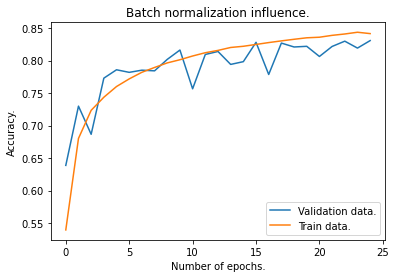

In [46]:
plt.plot(val_history, label="Validation data.")
plt.plot(train_history, label="Train data.")
plt.xlabel("Number of epochs.")
plt.ylabel("Accuracy.")
plt.title('Batch normalization influence.')
plt.legend()

## Let's build a model with an intuition we got.
For this model we'll use Adam optimizer.

In [47]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 200),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(200),
            nn.Linear(200, 200),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(200),
            nn.Linear(200, 10), 
         )
nn_model.type(torch.FloatTensor)
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)

In [55]:
if USE_GPU and torch.cuda.is_available():
    try:
        DEVICE = torch.device("cuda:0")
        print('using device: cuda')
    except:
        print('using device: cpu')
        DEVICE = torch.device('cpu')

using device: cuda


In [49]:
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)
loss_history, train_history, val_history = train_model(nn_model, train_loader, 
                                                       val_loader, loss, optimizer, 75,
                                                       learning_rate_decay=1e-3, verbose=True)

Epoch: 1, Average loss: 1.307570, Train accuracy: 0.572586, Val accuracy: 0.705686
Epoch: 2, Average loss: 0.936629, Train accuracy: 0.705167, Val accuracy: 0.755716
Epoch: 3, Average loss: 0.818405, Train accuracy: 0.743234, Val accuracy: 0.769163
Epoch: 4, Average loss: 0.743838, Train accuracy: 0.766628, Val accuracy: 0.785202
Epoch: 5, Average loss: 0.687948, Train accuracy: 0.784152, Val accuracy: 0.796942
Epoch: 6, Average loss: 0.652820, Train accuracy: 0.796591, Val accuracy: 0.798922
Epoch: 7, Average loss: 0.623772, Train accuracy: 0.804781, Val accuracy: 0.818306
Epoch: 8, Average loss: 0.602235, Train accuracy: 0.811862, Val accuracy: 0.823493
Epoch: 9, Average loss: 0.571140, Train accuracy: 0.820855, Val accuracy: 0.815985
Epoch: 10, Average loss: 0.557215, Train accuracy: 0.824728, Val accuracy: 0.823630
Epoch: 11, Average loss: 0.539413, Train accuracy: 0.830700, Val accuracy: 0.828885
Epoch: 12, Average loss: 0.523552, Train accuracy: 0.835972, Val accuracy: 0.829909
E

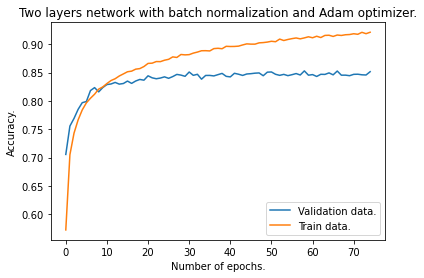

In [50]:
plt.plot(val_history, label="Validation data.")
plt.plot(train_history, label="Train data.")
plt.xlabel("Number of epochs.")
plt.ylabel("Accuracy.")
plt.title('Two layers network with batch normalization and Adam optimizer.')
plt.legend()

## Let's check our model against testing data.

In [60]:
DEVICE = torch.device("cpu")
test_loader = torch.utils.data.DataLoader(data_test, batch_size=32)
test_accuracy = compute_accuracy(nn_model, test_loader, DEVICE)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8515
